# Statsmodels dan lasso regression buat ngecek regresi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',False)
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

Original data

In [2]:
df = pd.read_csv('data_clean.csv')
df = df[df['tipe']=='Rumah']
df = df.drop(['Unnamed: 0','tipe','deskripsi'], axis = 1)
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12266 entries, 0 to 13495
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   kamar_mandi    12266 non-null  int64  
 1   kamar_tidur    12266 non-null  int64  
 2   luas_bangunan  12266 non-null  float64
 3   luas_tanah     12266 non-null  float64
 4   harga          12266 non-null  float64
 5   kecamatan      12266 non-null  object 
 6   garasi         12266 non-null  bool   
 7   kolam_renang   12266 non-null  bool   
 8   taman          12266 non-null  bool   
 9   gym            12266 non-null  bool   
 10  listrik        12266 non-null  float64
 11  jumlah_lantai  12266 non-null  int64  
dtypes: bool(4), float64(4), int64(3), object(1)
memory usage: 910.4+ KB


In [3]:
df.describe()

,kamar_mandi,kamar_tidur,luas_bangunan,luas_tanah,harga,listrik,jumlah_lantai
count,12266.000000,12266.000000,12266.000000,12266.000000,1.226600e+04,12266.000000,12266.000000
mean,3.852275,4.735448,275.072232,240.828632,7.561198e+09,5916.777026,2.056579
std,1.590030,1.927604,271.628134,292.248694,1.451699e+10,8574.285920,0.671032
min,1.000000,1.000000,21.000000,22.000000,9.500000e+07,130.000000,1.000000
25%,3.000000,4.000000,120.000000,90.000000,1.650000e+09,2200.000000,2.000000
50%,4.000000,4.000000,196.000000,144.000000,3.000000e+09,2200.000000,2.000000
75%,5.000000,5.000000,332.000000,270.000000,6.800000e+09,5500.000000,2.000000
max,28.000000,43.000000,6075.000000,7000.000000,3.750000e+11,85000.000000,5.000000


Margin Of Error (jumlah rumah ~ jumlah rumah tangga, sumber: bps)

In [4]:
from math import sqrt

In [5]:
N = 2659205 #population size
n = len(df) #sample size
error = sqrt((N-n)/(N*n))
error*100

0.90083360094615

In [6]:
num = [i for i in df.columns if df[i].dtypes in ['int64', 'float']]
cat = [i for i in df.columns if df[i].dtypes in ['O', 'bool']]

In [7]:
df[cat] = df[cat].astype('O')

Encoding samain, gausah pake decision tree encoder

In [8]:
from feature_engine.encoding import OrdinalEncoder as OE

x = independent variables

In [9]:
oe = OE(variables = [i for i in cat])
oe.fit(df,df['harga'])
x = oe.transform(df)

In [10]:
from sklearn.preprocessing import StandardScaler as ss

In [11]:
x_scale = ss()
x_scale.fit(x.drop('harga',axis = 1))
y_scale = ss()
y_scale.fit(x[['harga']])

StandardScaler()

Statsmodels buat ngecek awal aja, cara seleksi feature salah satunya bisa pake statsmodels

In [12]:
import statsmodels.api as sm

In [13]:
x = x_scale.transform(x.drop(['harga'],axis = 1))
x = pd.DataFrame(x)
x.columns = df.drop('harga', axis = 1).columns

y = y_scale.transform(df[['harga']])
y = pd.DataFrame(y)
y.columns = ['harga']
initial_data = pd.concat([x,y],axis = 1)
x = sm.add_constant(x)

In [14]:
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  harga   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     1448.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:49:46   Log-Likelihood:                -12297.
No. Observations:               12266   AIC:                         2.462e+04
Df Residuals:                   12254   BIC:                         2.471e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.469e-17      0.006   5.82e-15      1.000      -0.012       0.012
kamar_mandi      -0.0074      0.009     -0.794      0.427      -0.026       0.011
kamar_tidur      -0.0208      0.009     -2.419      0.016      -0.038      -0.004
luas_bangunan     0.4355      0.010     44.835      0.000       0.416       0.455
luas_tanah        0.2834      0.009     31.984      0.000       0.266       0.301
kecamatan         0.1725      0.007     26.128      0.000       0.160       0.185
garasi           -0.0043      0.006     -0.691      0.489      -0.016       0.008
kolam_renang      0.0216      0.007      3.315      0.001       0.009       0.034
taman             0.0032      0.006      0.521      0.602      -0.009       0.015
gym               0.0179      0.006      2.947      0.003       0.006       0.030
listrik           0.0370      0.006      5.969      0.000       0.025       0.049
jumlah_lantai    -0.0364      0.006     -5.725      0.000      -0.049      -0.024
==============================================================================
Omnibus:                    13586.517   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9702758.137
Skew:                           4.901   Prob(JB):                         0.00
Kurtosis:                     140.436   Cond. No.                         3.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
pd.DataFrame(model.params).reset_index().sort_values(by = 0, ascending = False)

,index,0
3,luas_bangunan,4.354865e-01
4,luas_tanah,2.834143e-01
5,kecamatan,1.724896e-01
10,listrik,3.698940e-02
7,kolam_renang,2.158777e-02
9,gym,1.787856e-02
8,taman,3.153954e-03
0,const,3.469447e-17
6,garasi,-4.270325e-03
1,kamar_mandi,-7.390255e-03


In [16]:
from sklearn.metrics import mean_squared_error as mse

RMSE value

In [17]:
y_pred = model.predict(x)
sqrt(mse(y_pred, y))

0.65942246409278

In [18]:
from scipy import stats

Cari pval>0.05(not statistically signifigance)

In [19]:
for k in cat+num:
    if df[k].nunique() <100:
        print("="*45,f' {k} ',"="*45)
        var = [i for i in df[k].unique()]
        pair = {}
        udah = []
        for i in var:
            for j in var:
                if (j not in udah) & (i != j):
                    ttest = stats.ttest_ind(a = df[df[k] == i]['harga'],
                                            b = df[df[k] == j]['harga'])
                    p_value = ttest.pvalue
                    pair[f'{i} - {j}'] = p_value
            udah.append(i)
        count = 0
        for i,j in pair.items():
            if j >= 0.05:
                print(i)
                count += 1
        print(f'{k}: {count/len(pair)*100}')
        print("="*100,end = '\n')

=============================================  kecamatan  =============================================
Mampang Prapatan - Tanah Abang
Cilandak - Tebet
Cilandak - Pasar Minggu
Cilandak - Pancoran
Cilandak - Gambir
Cilandak - Palmerah
Kebayoran Baru - Kebayoran Lama
Kebayoran Baru - Setiabudi
Jagakarsa - Koja
Jagakarsa - Cakung
Jagakarsa - Kramat Jati
Jagakarsa - Makasar
Jagakarsa - Matraman
Jagakarsa - Johar Baru
Jagakarsa - Kalideres
Jagakarsa - Cengkareng
Tebet - Pasar Minggu
Tebet - Jatinegara
Tebet - Gambir
Tebet - Senen
Tebet - Palmerah
Pasar Minggu - Pancoran
Pasar Minggu - Jatinegara
Pasar Minggu - Gambir
Pasar Minggu - Palmerah
Kebayoran Lama - Setiabudi
Pesanggrahan - Tanjung Priok
Pesanggrahan - Kelapa Gading
Pesanggrahan - Pademangan
Pesanggrahan - Pulo Gadung
Pesanggrahan - Jatinegara
Pesanggrahan - Kemayoran
Pesanggrahan - Cempaka Putih
Pesanggrahan - Sawah Besar
Pesanggrahan - Johar Baru
Pesanggrahan - Senen
Pesanggrahan - Palmerah
Pesanggrahan - Kembangan
Pesanggrahan - 

EDA original data

kamar_mandi


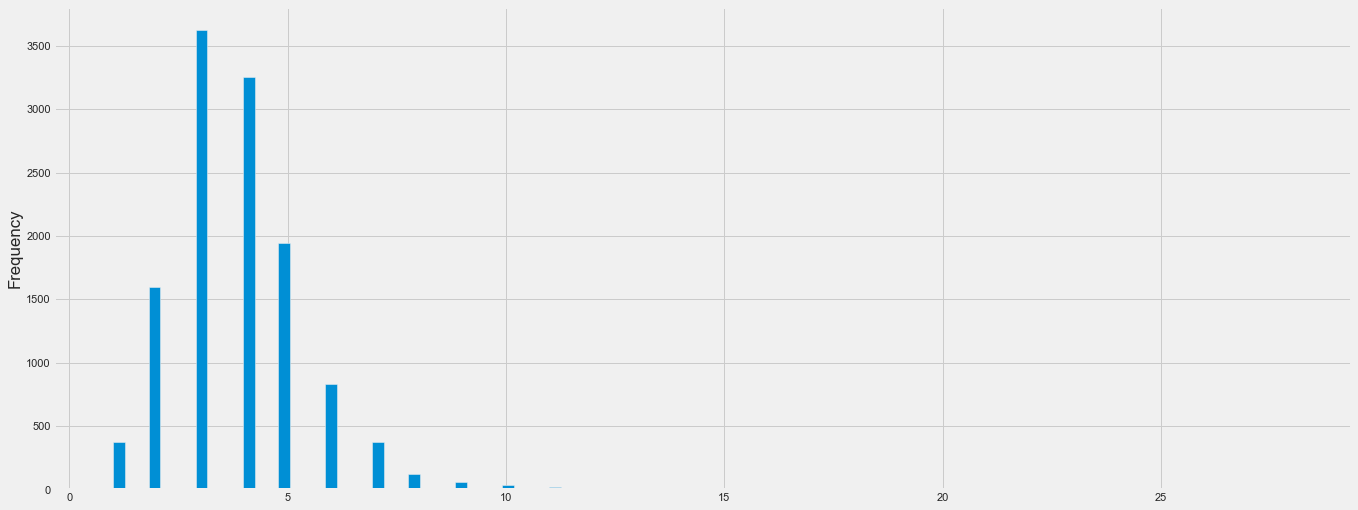

kamar_tidur


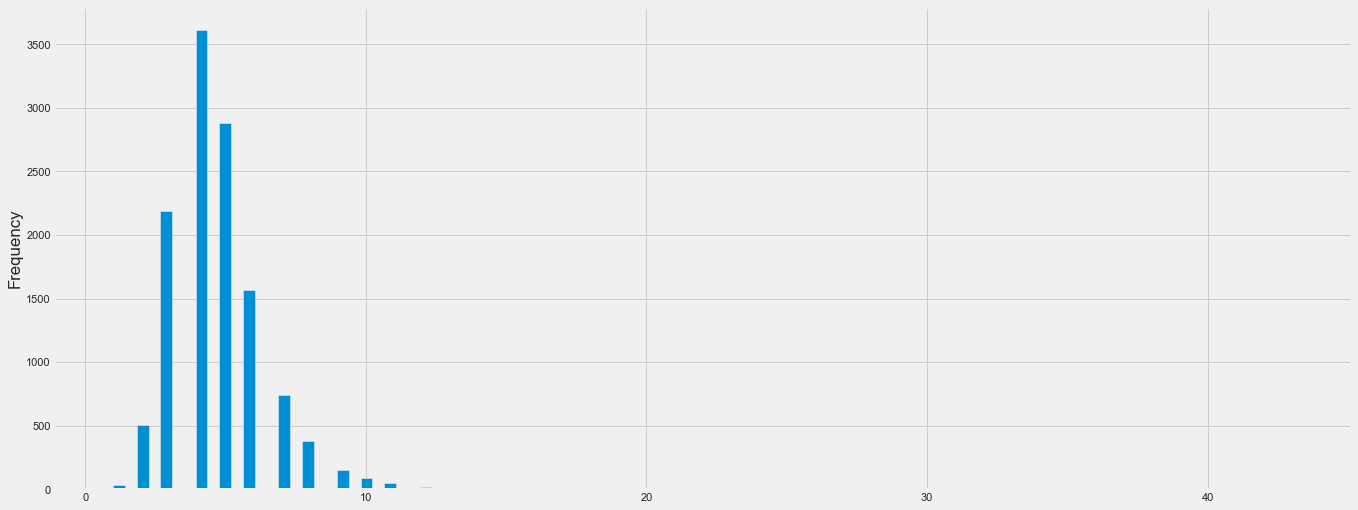

luas_bangunan


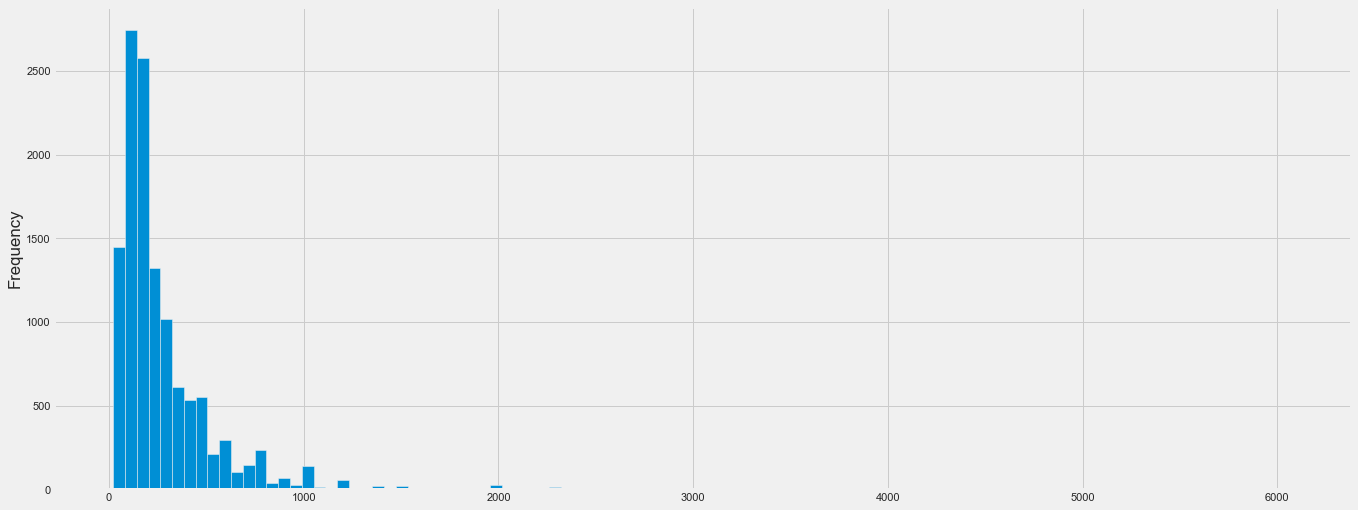

luas_tanah


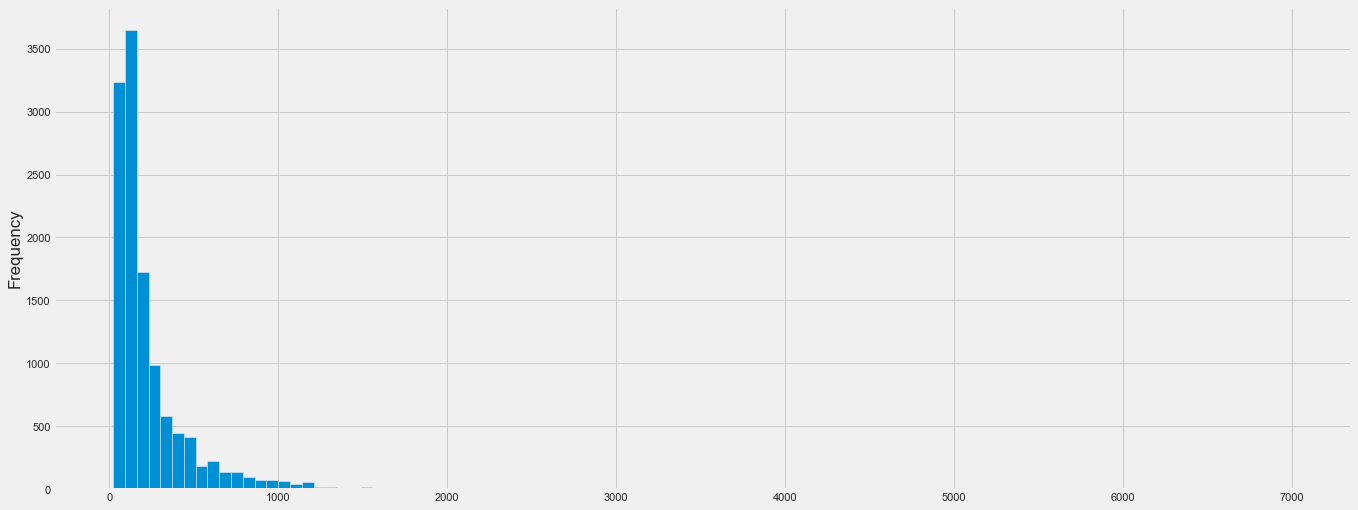

harga


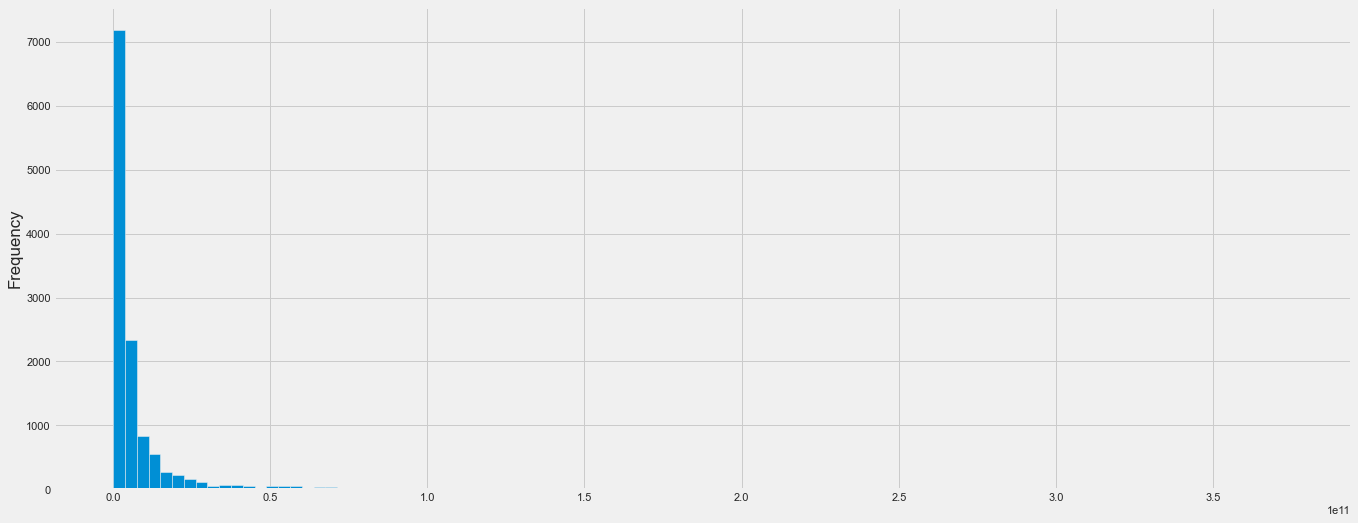

listrik


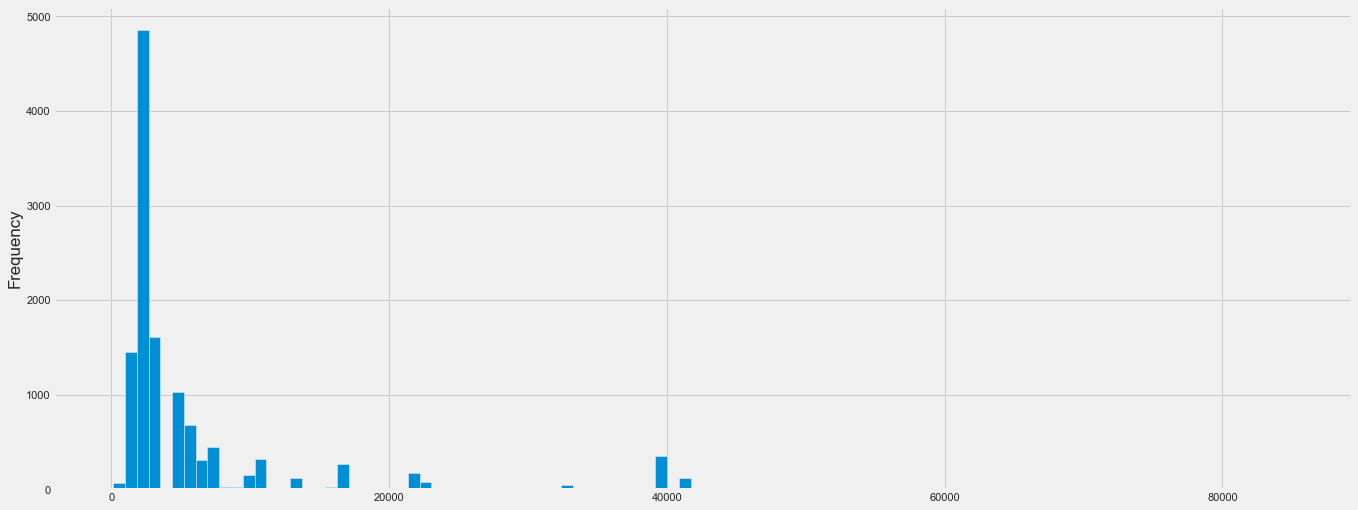

jumlah_lantai


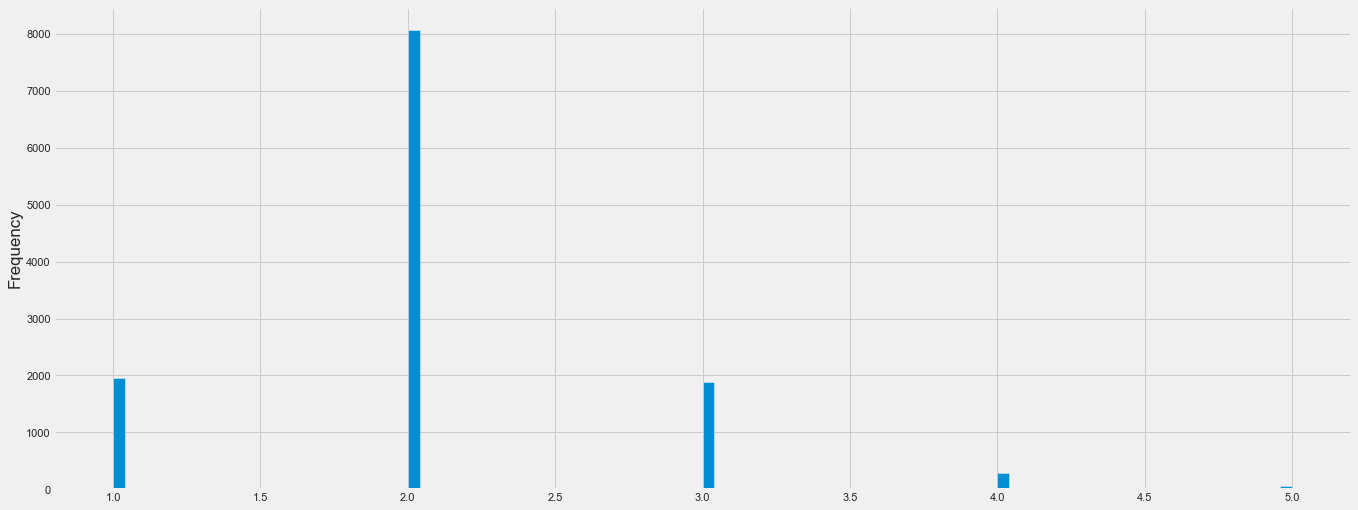

In [20]:
for i in num:
    print(i)
    df[i].plot.hist(bins = 100)
    plt.show()

kamar_mandi


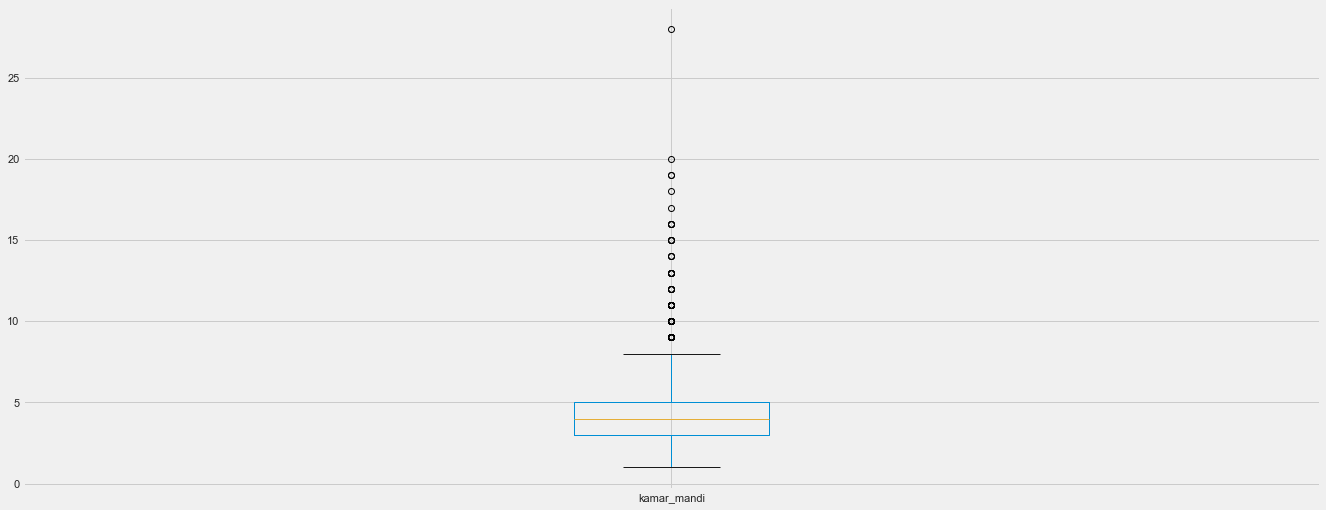

kamar_tidur


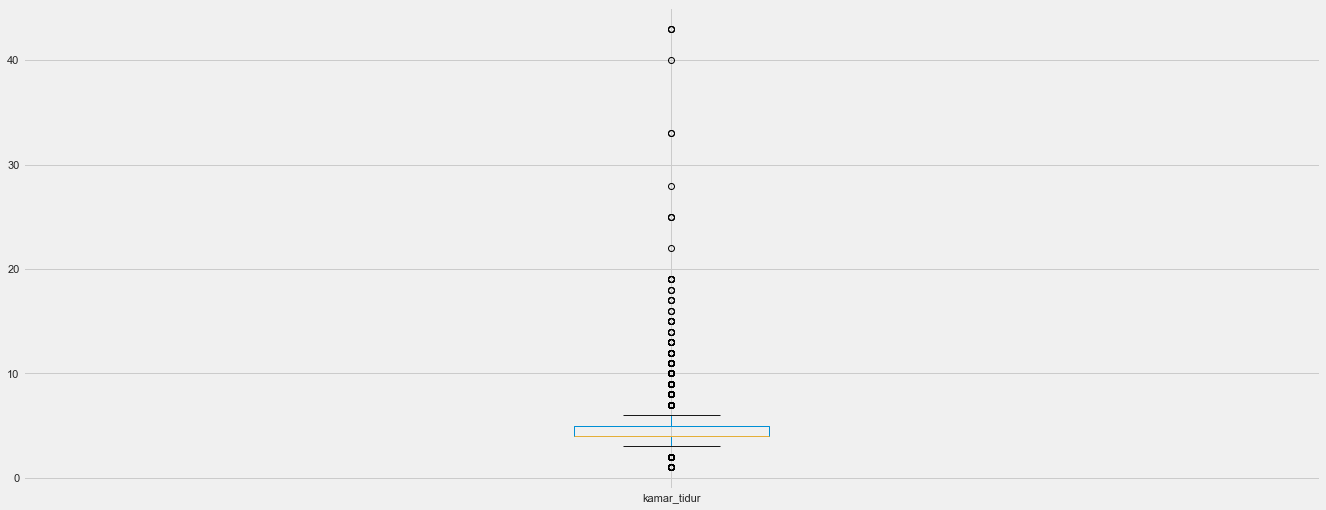

luas_bangunan


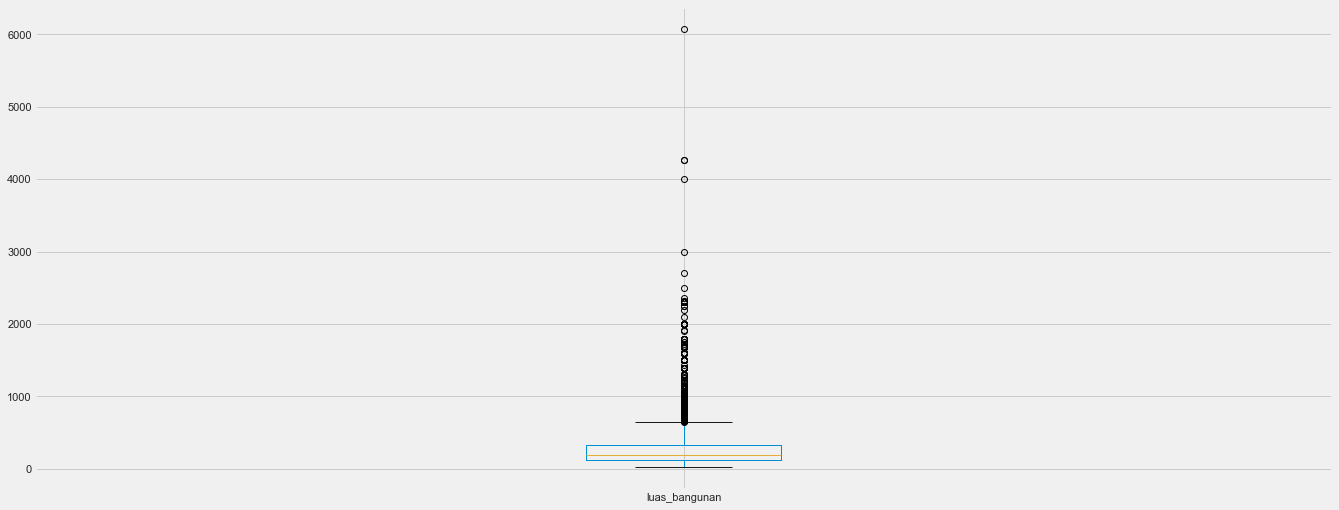

luas_tanah


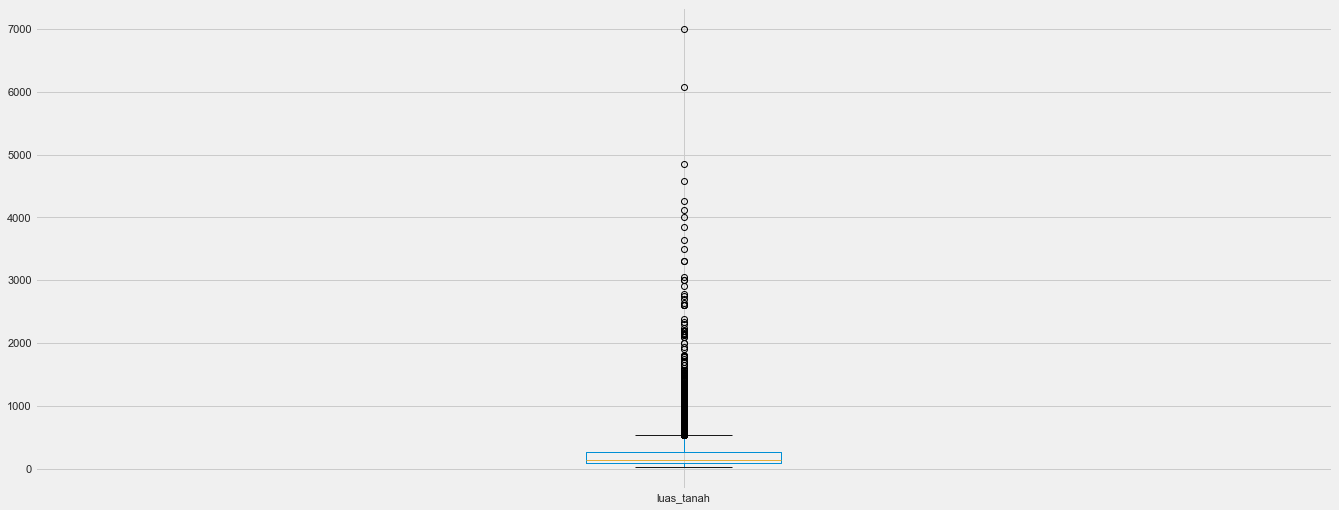

harga


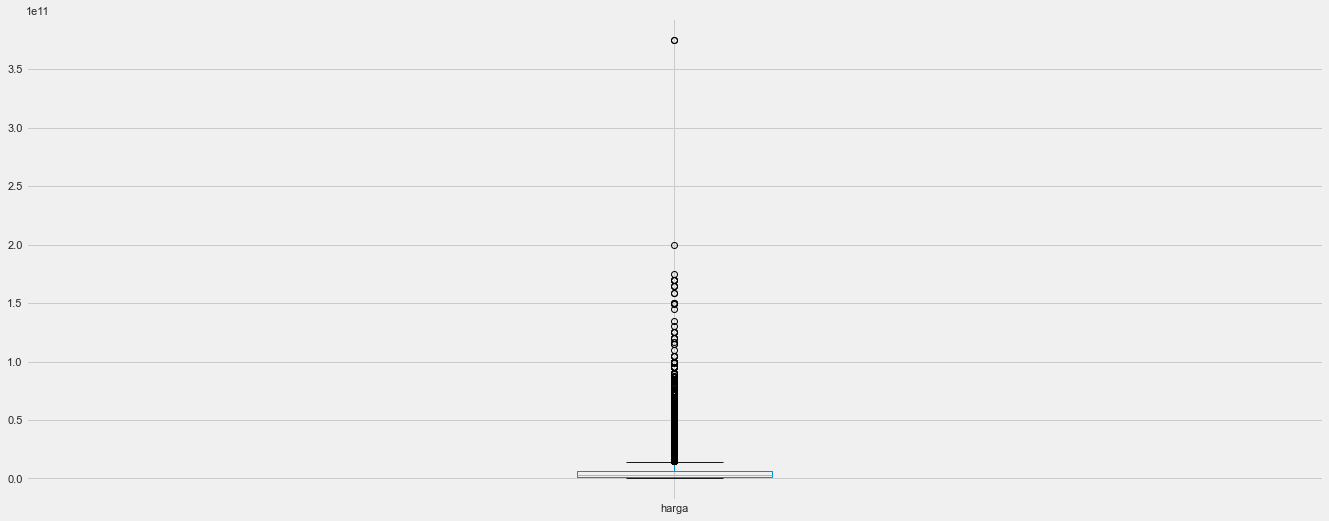

listrik


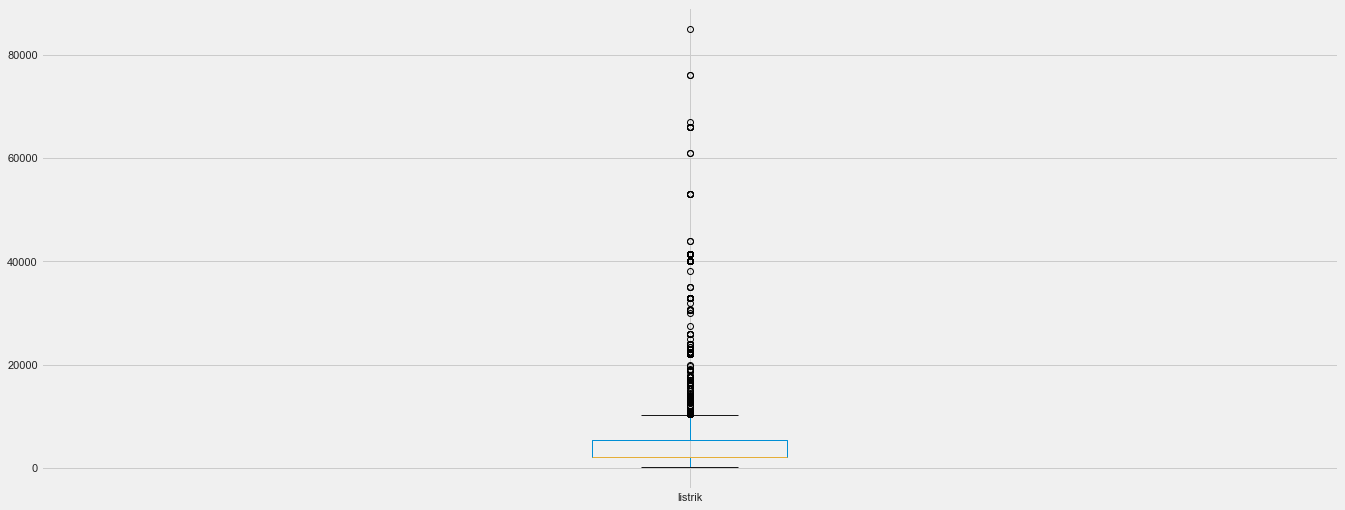

jumlah_lantai


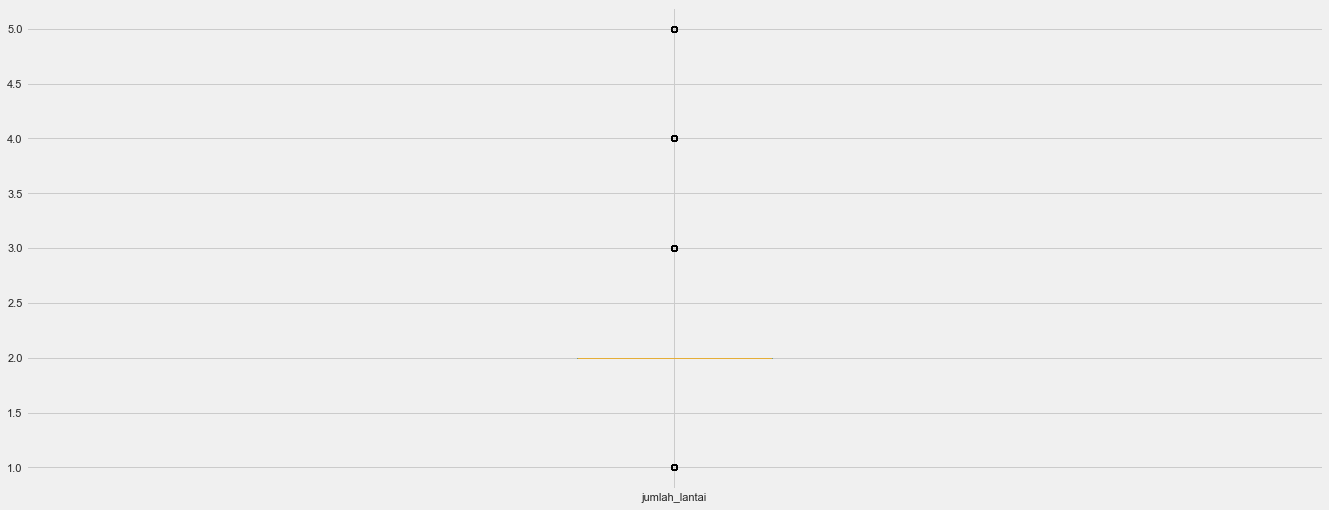

In [21]:
for i in num:
    print(i)
    df[i].plot.box()
    plt.show()

kecamatan


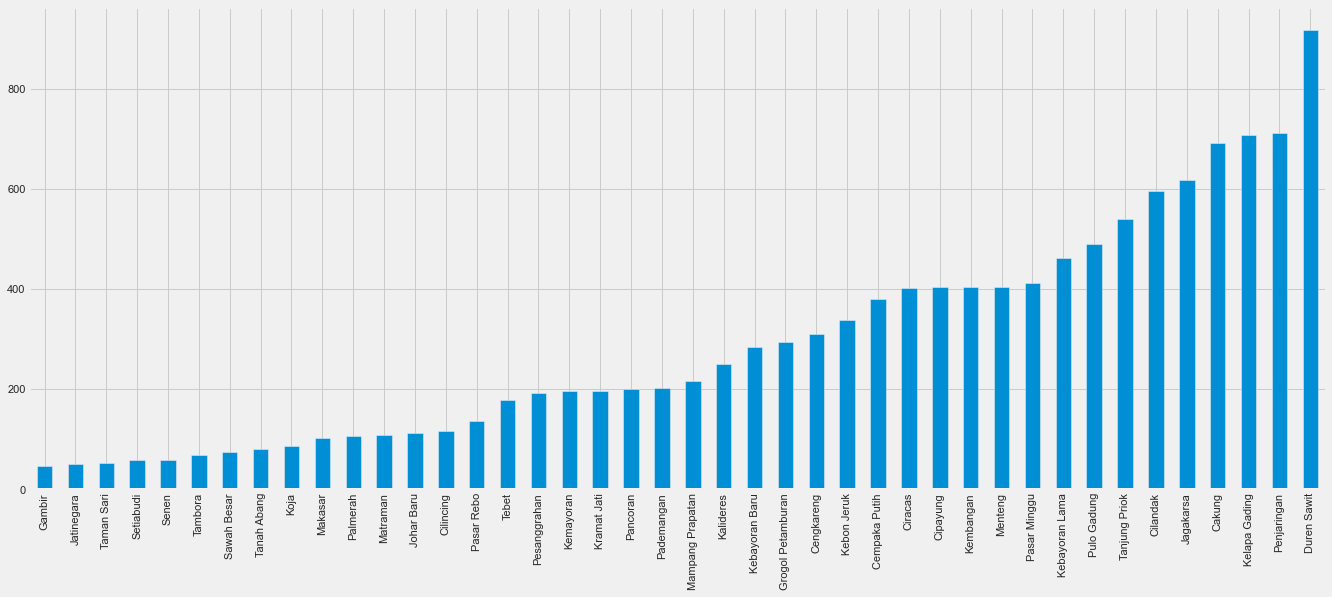

garasi


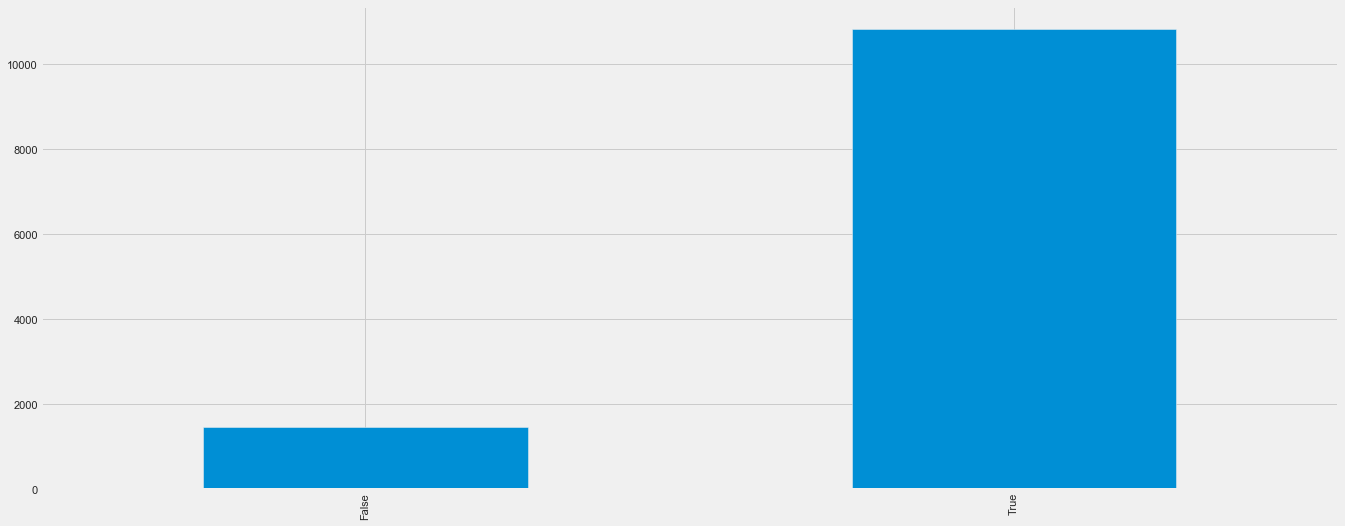

kolam_renang


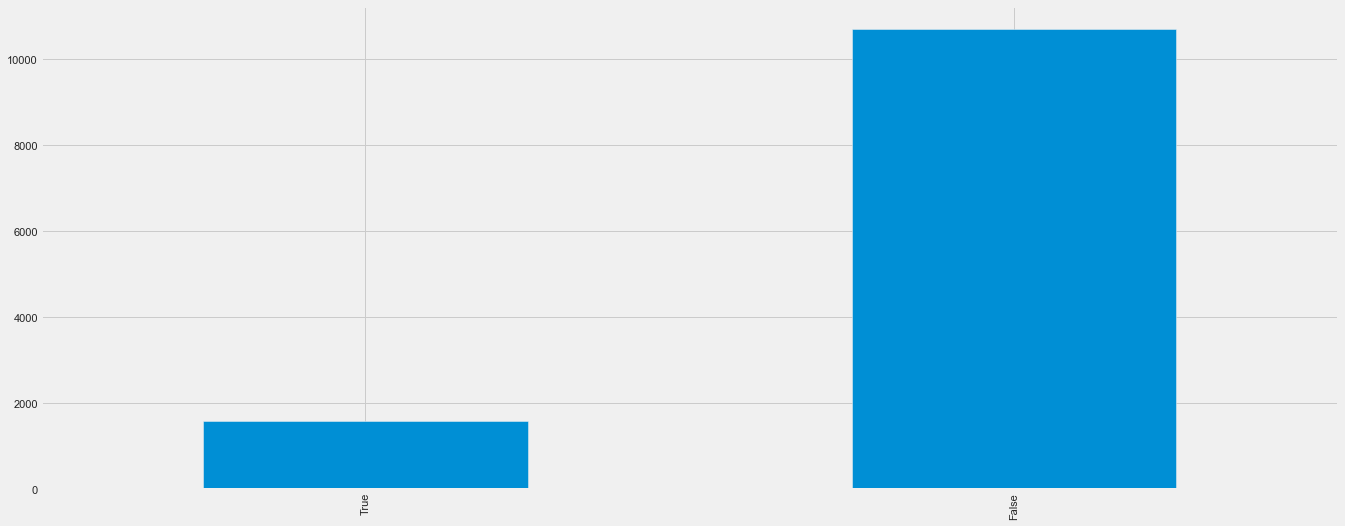

taman


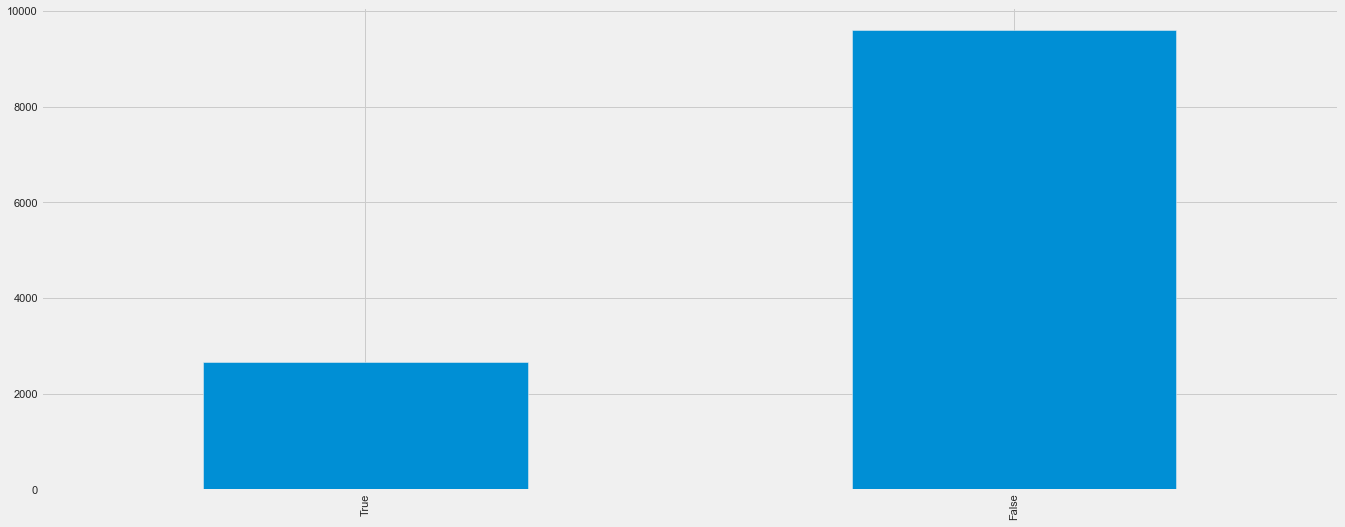

gym


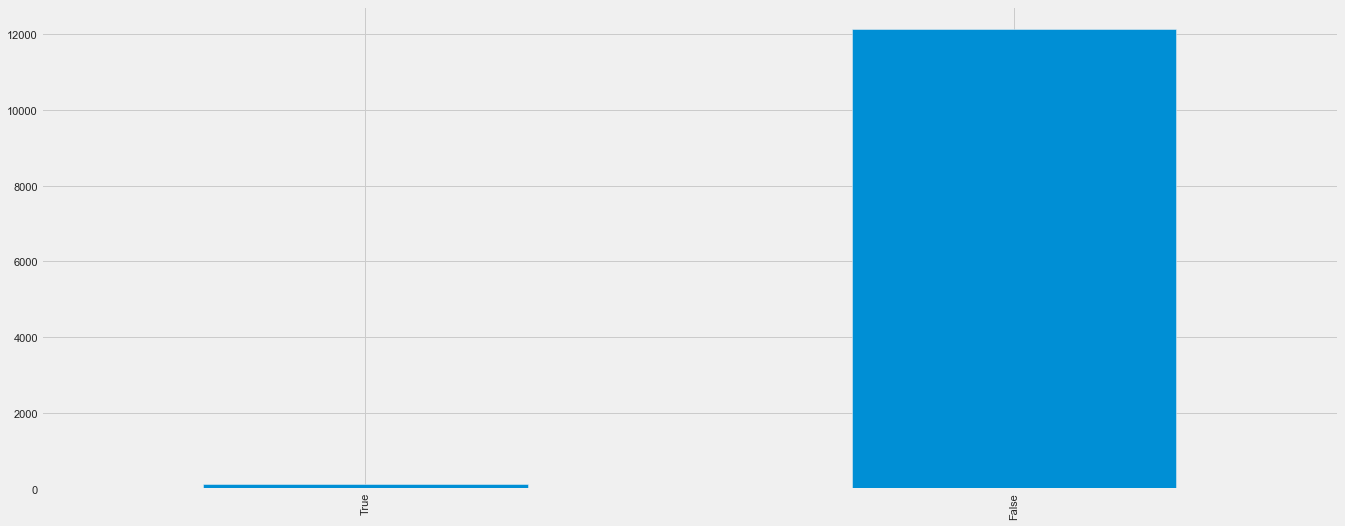

In [22]:
for i in cat:
    print(i)
    df[i].value_counts().sort_values().plot.bar()
    plt.show()

Masukin target (harga)

kamar_mandi


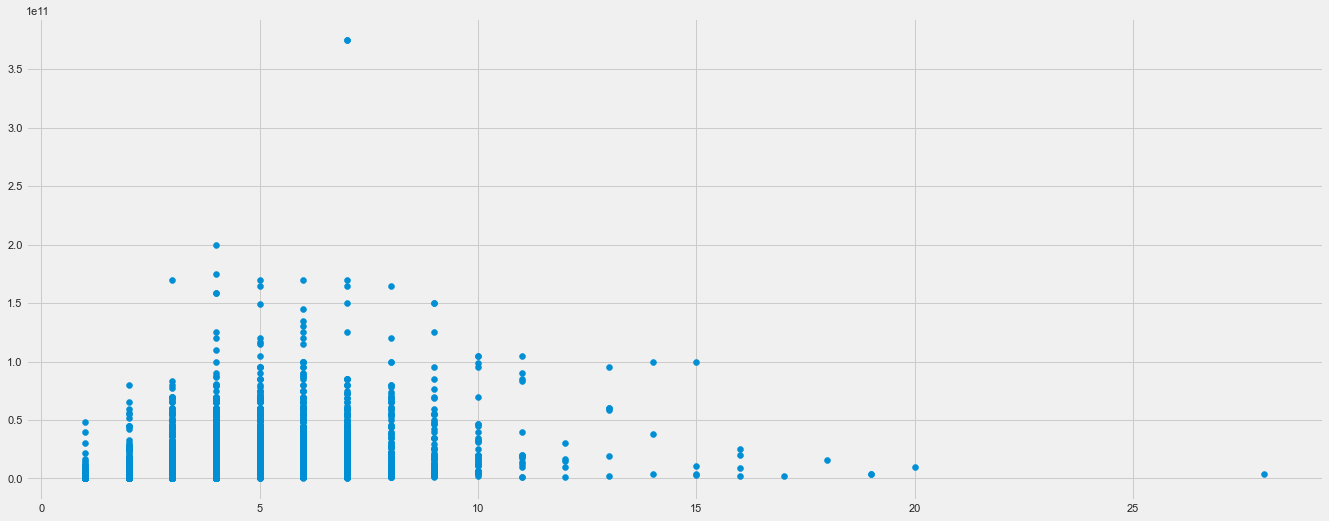

kamar_tidur


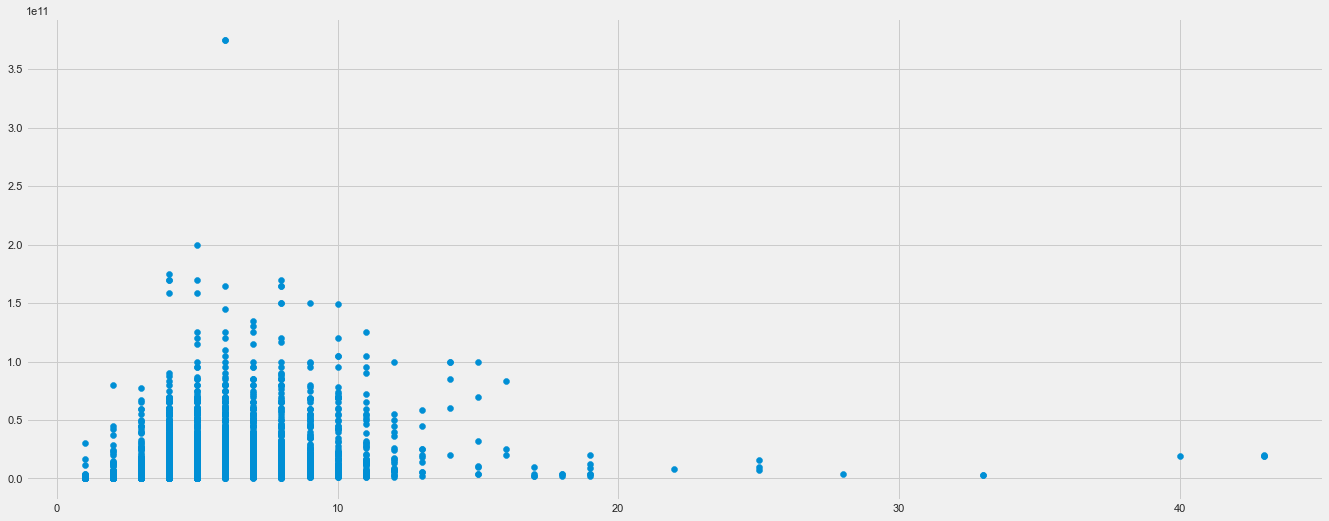

luas_bangunan


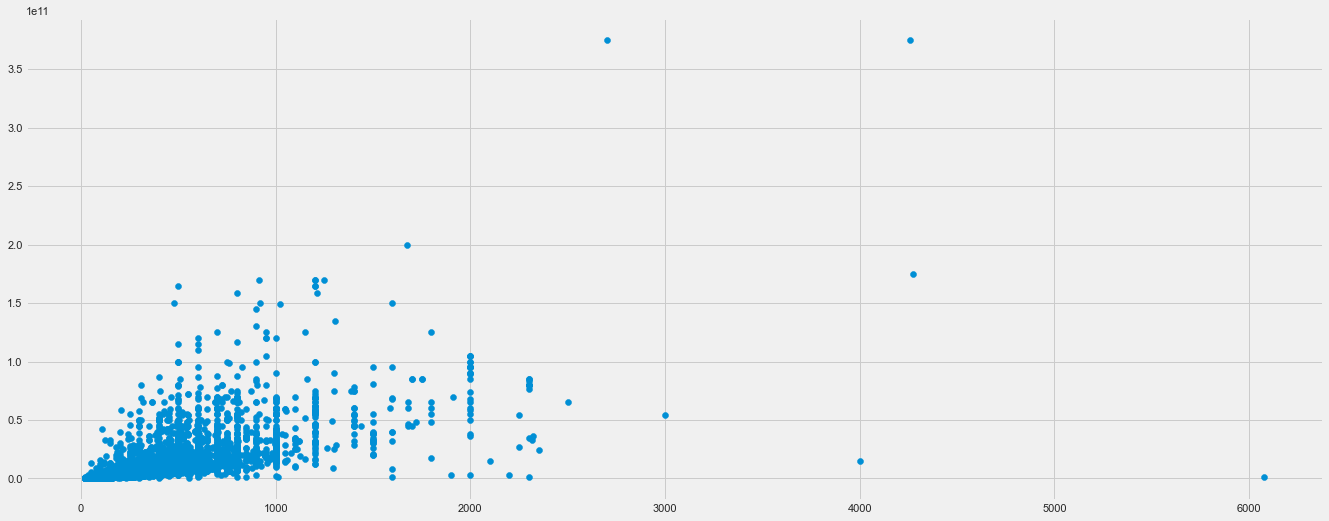

luas_tanah


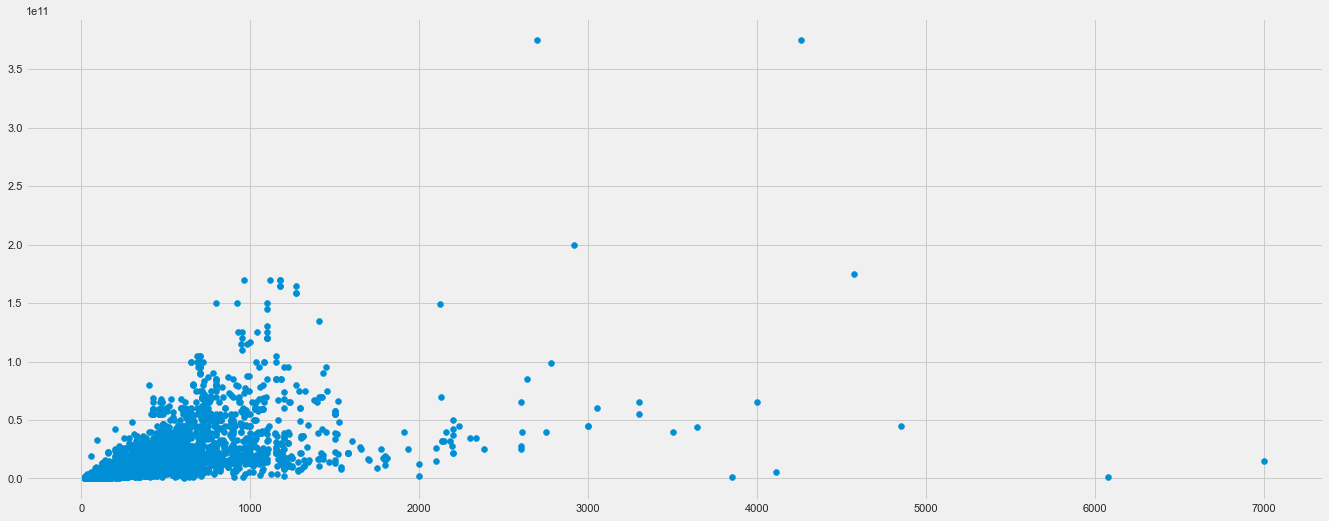

listrik


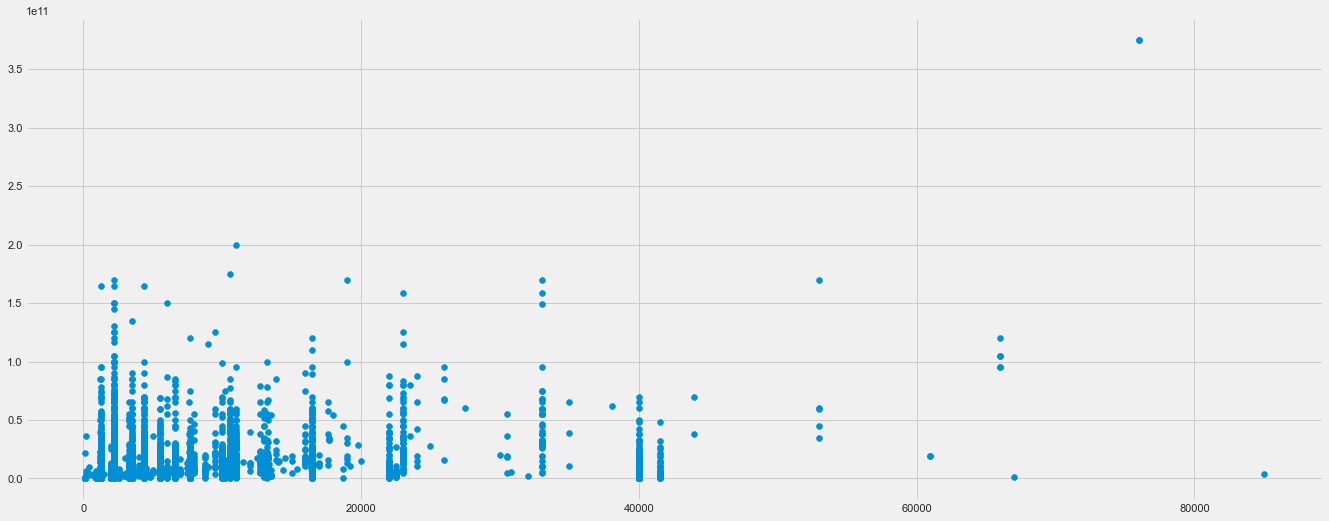

jumlah_lantai


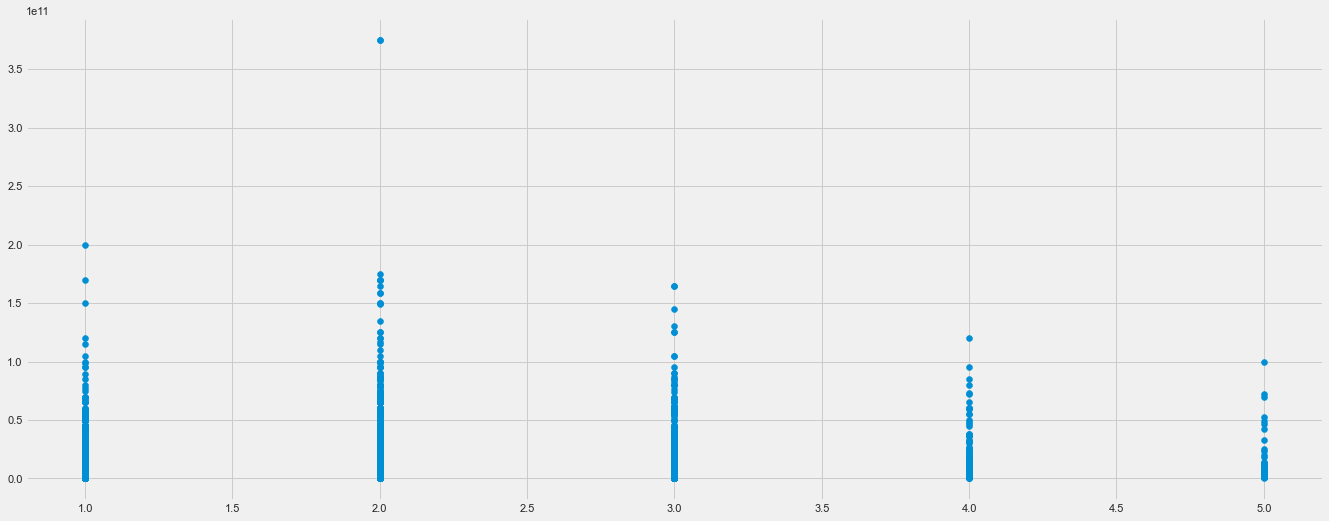

kecamatan


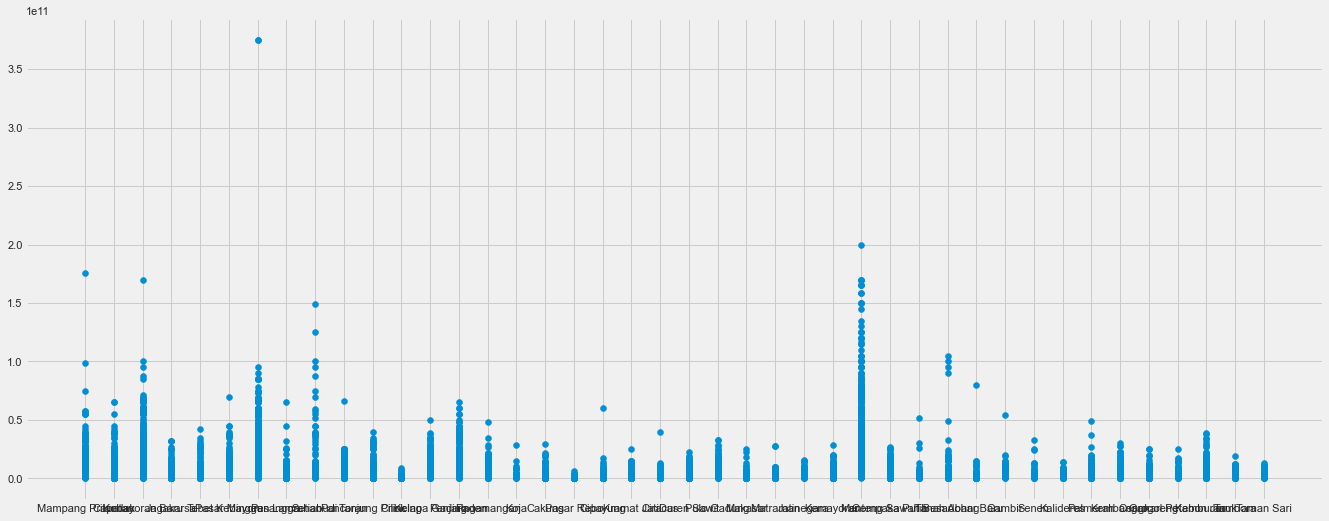

garasi


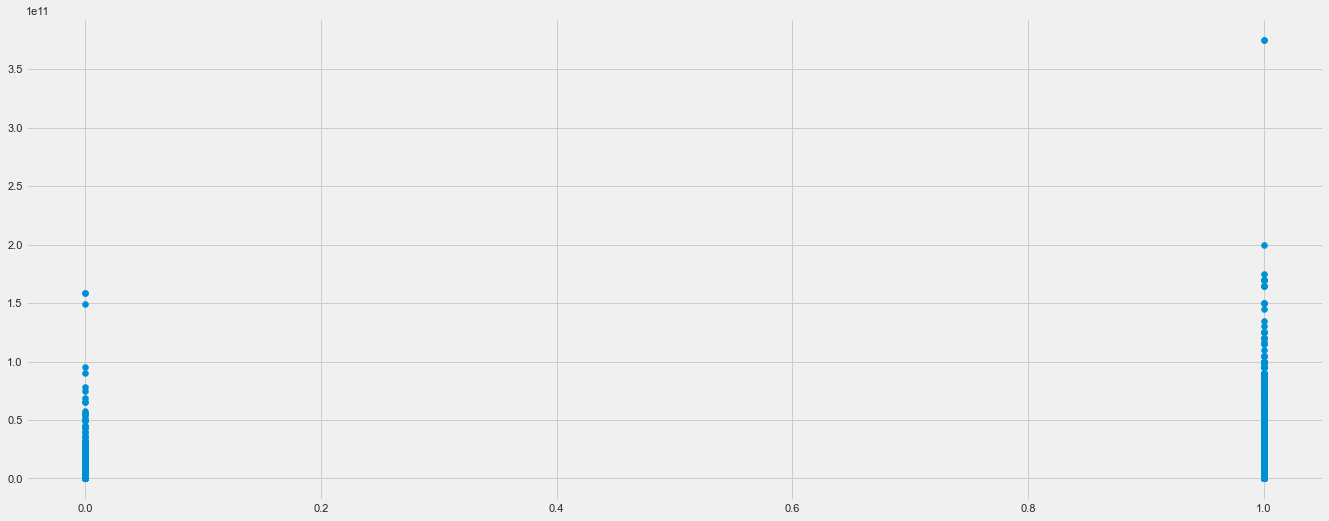

kolam_renang


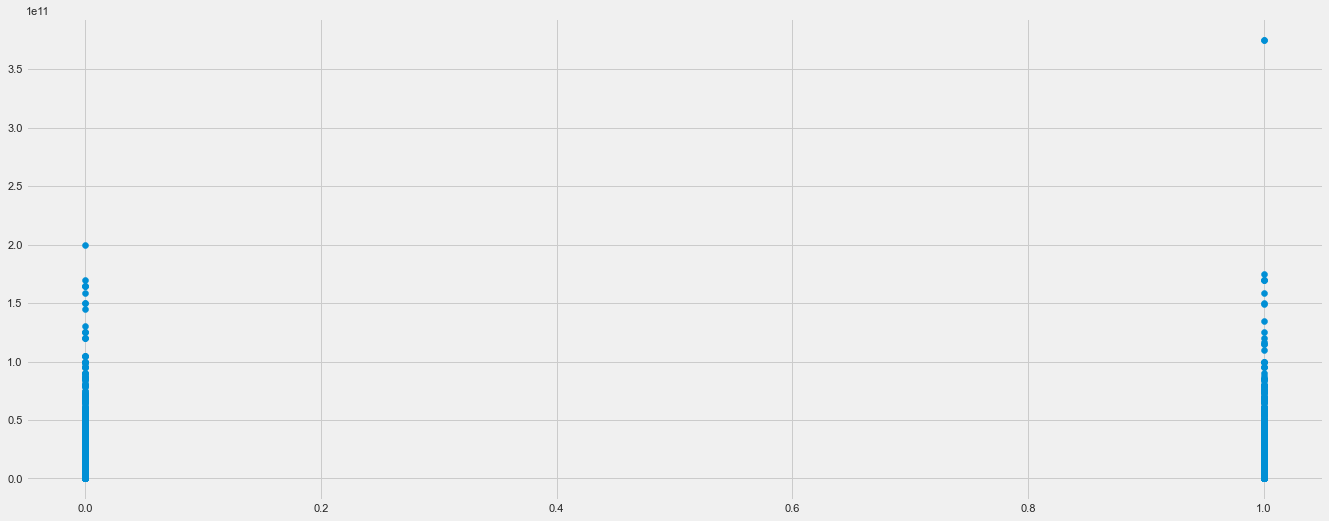

taman


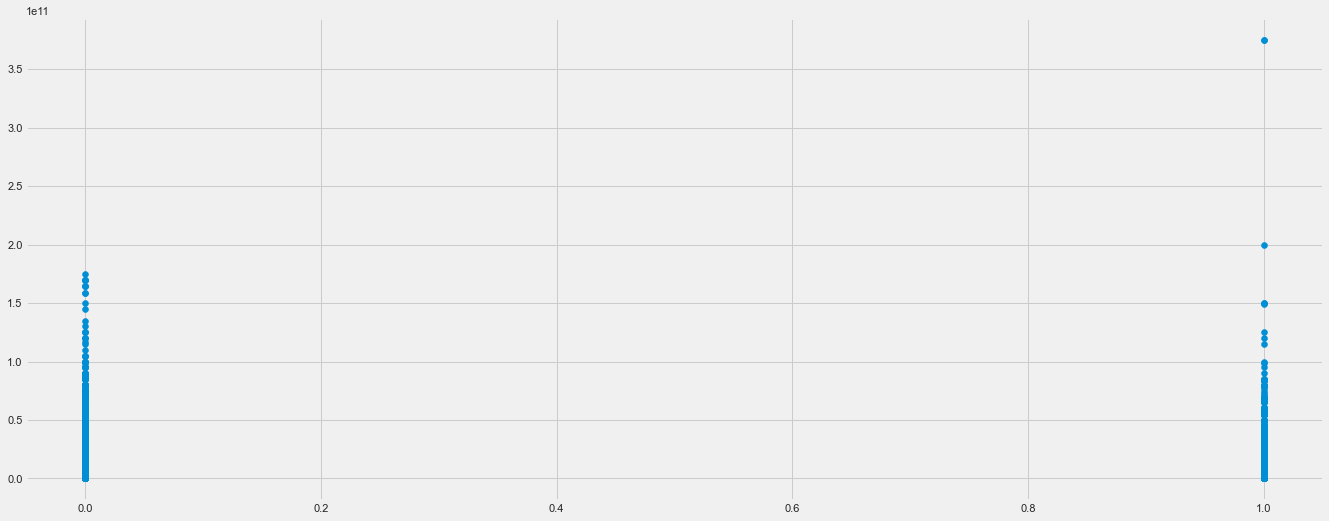

gym


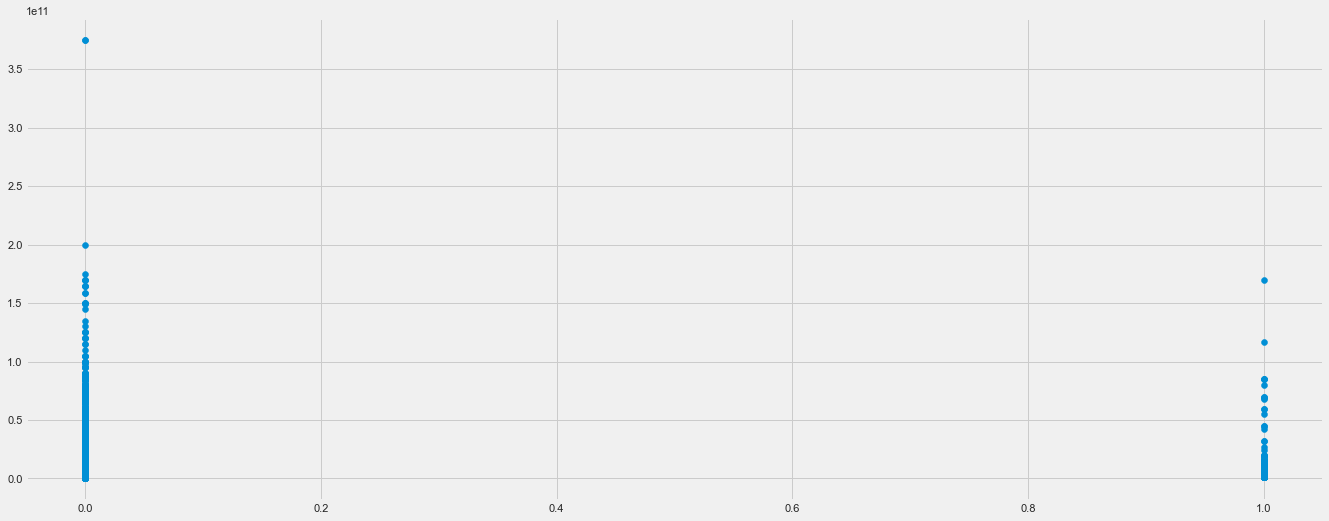

In [23]:
for i in num+cat:
    if i != 'harga':
        print(i)
        plt.scatter(df[i],df['harga'])
        plt.show()

kecamatan


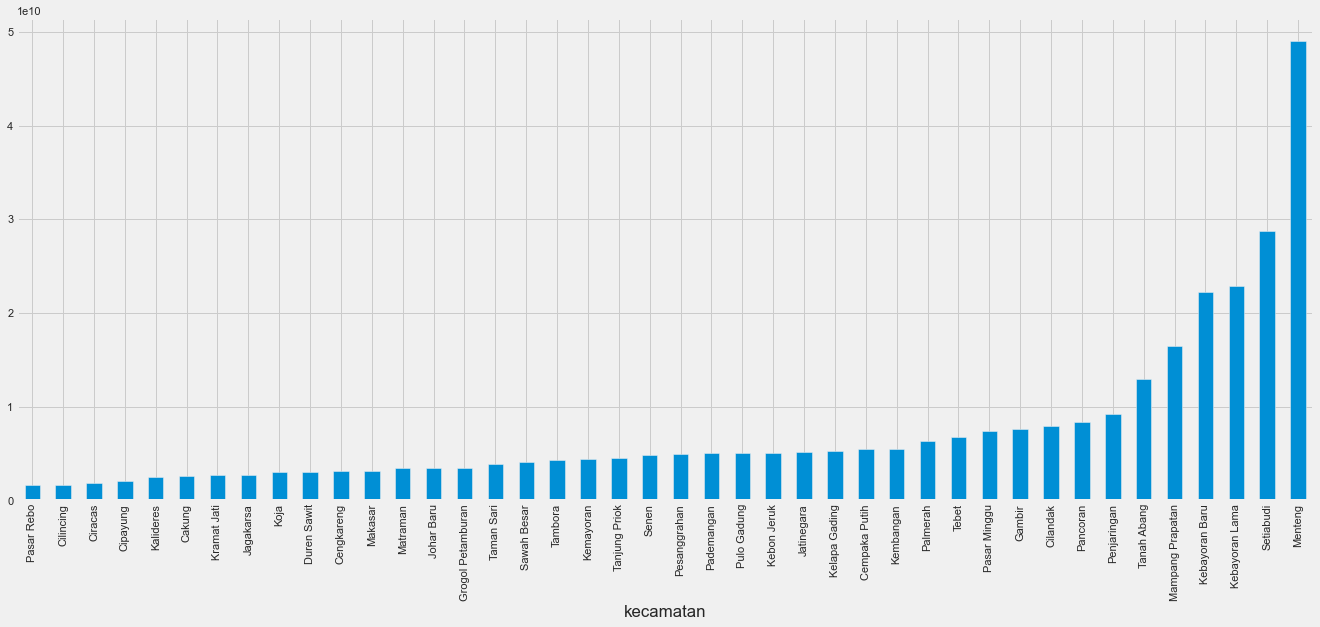

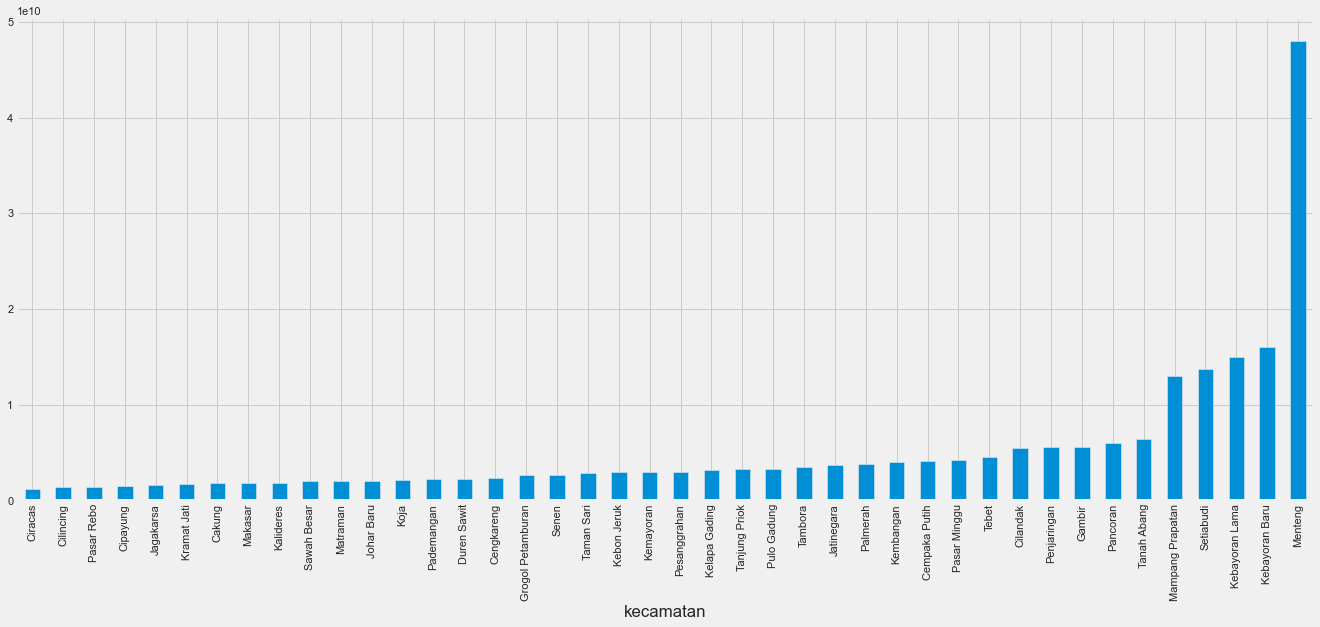

garasi


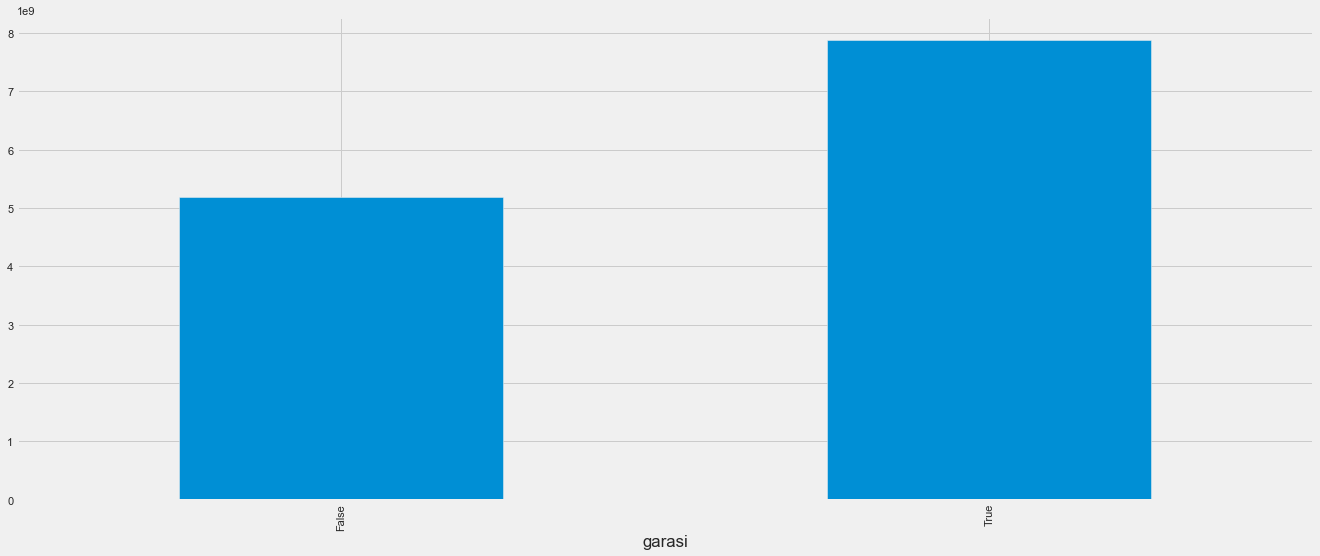

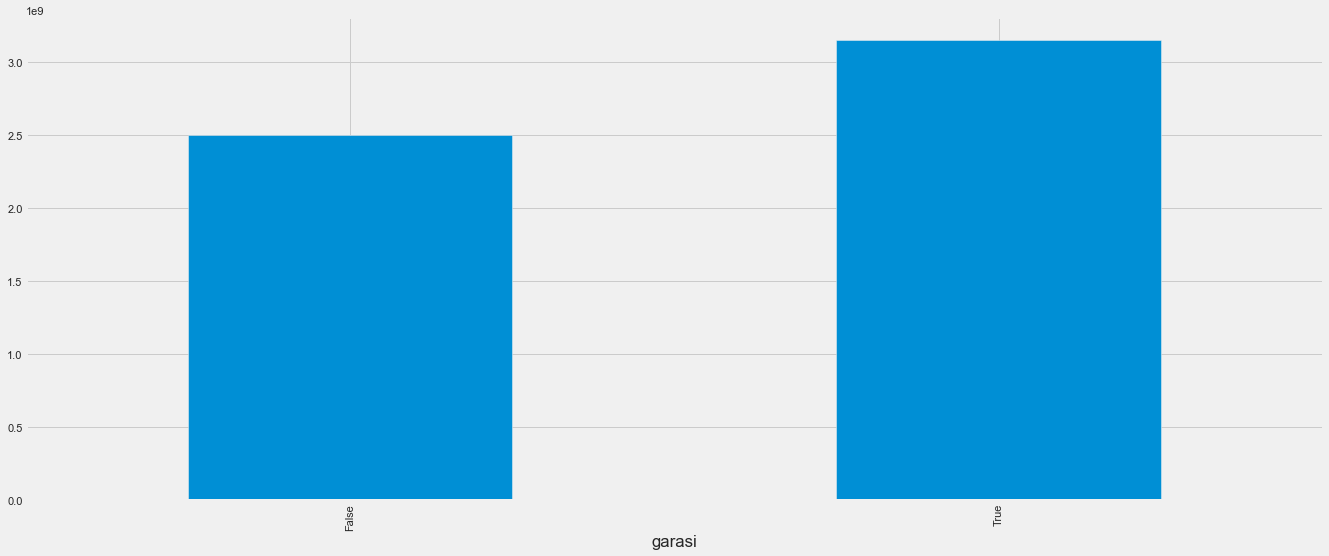

kolam_renang


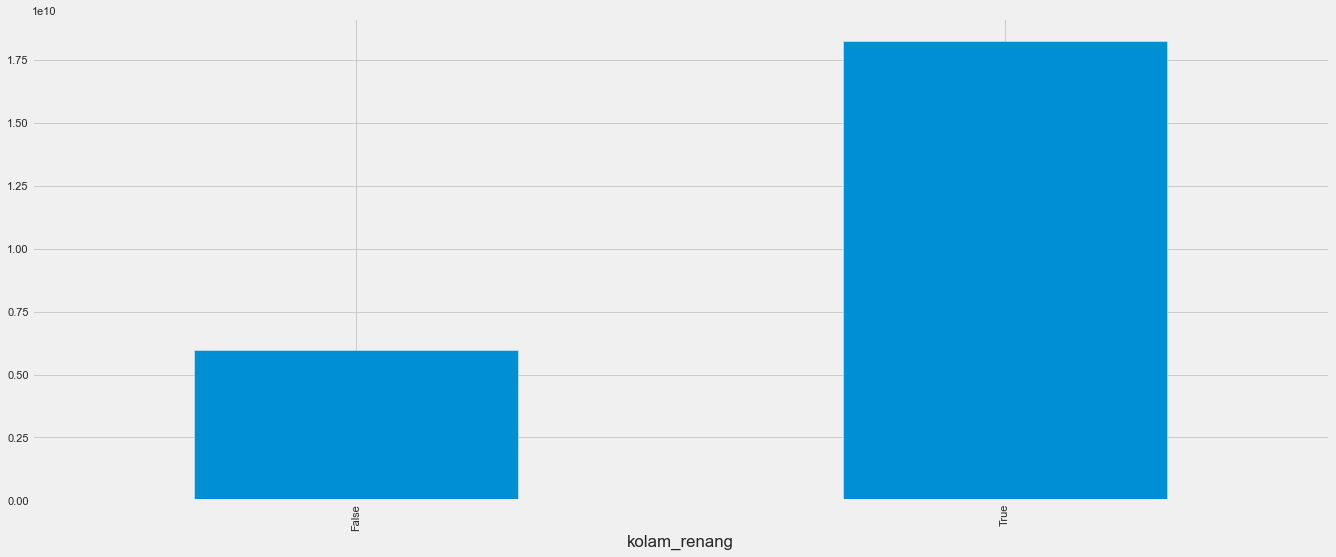

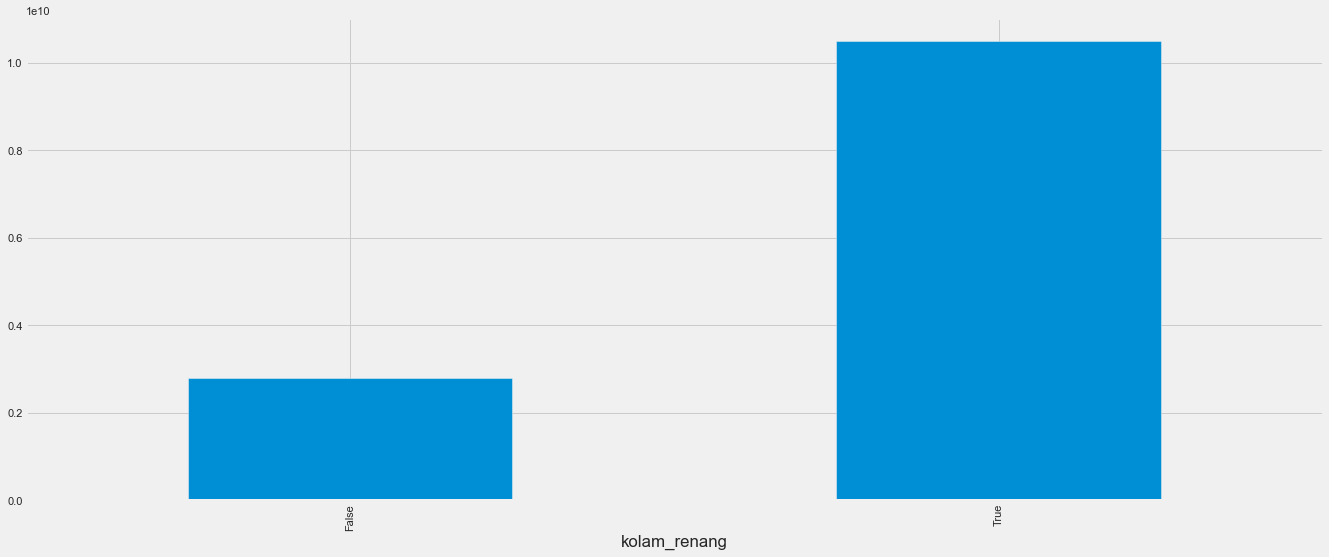

taman


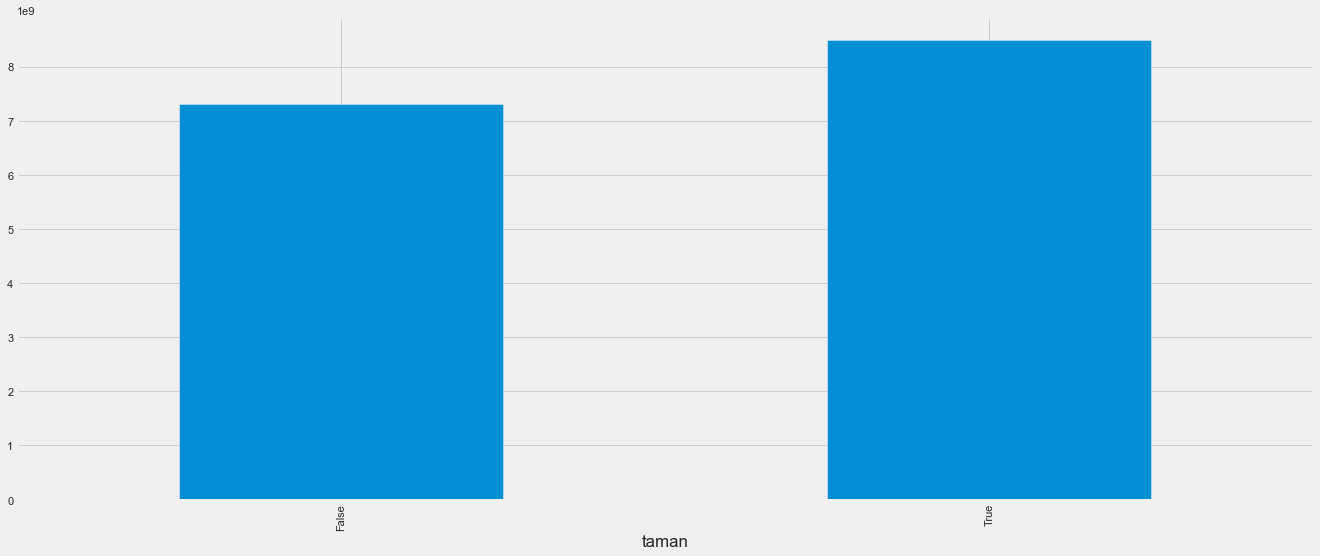

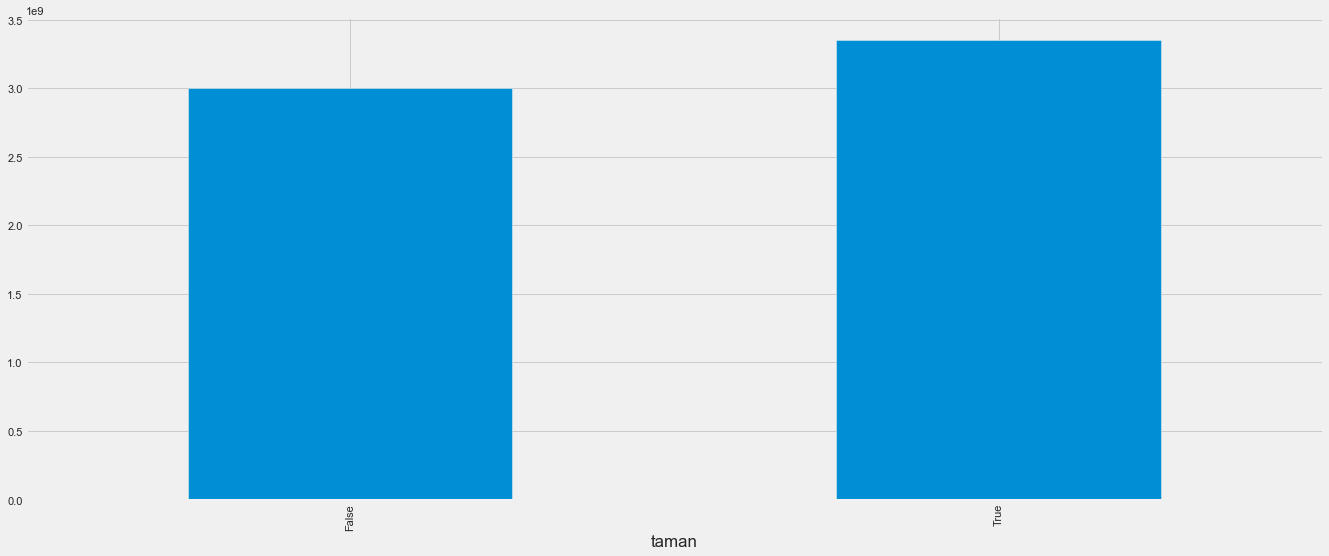

gym


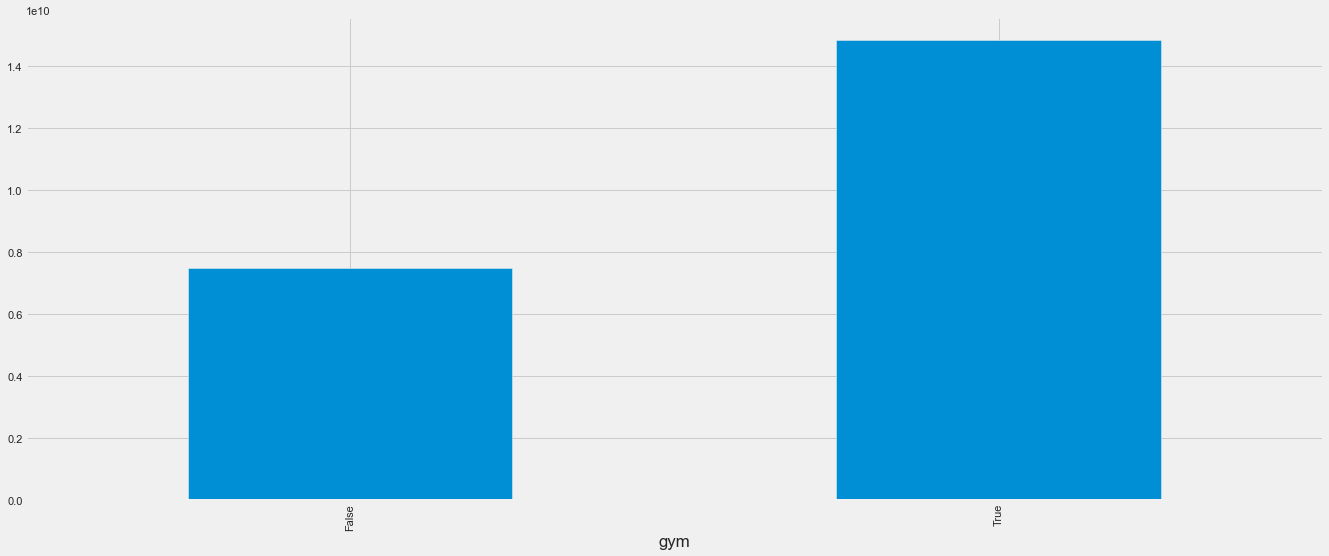

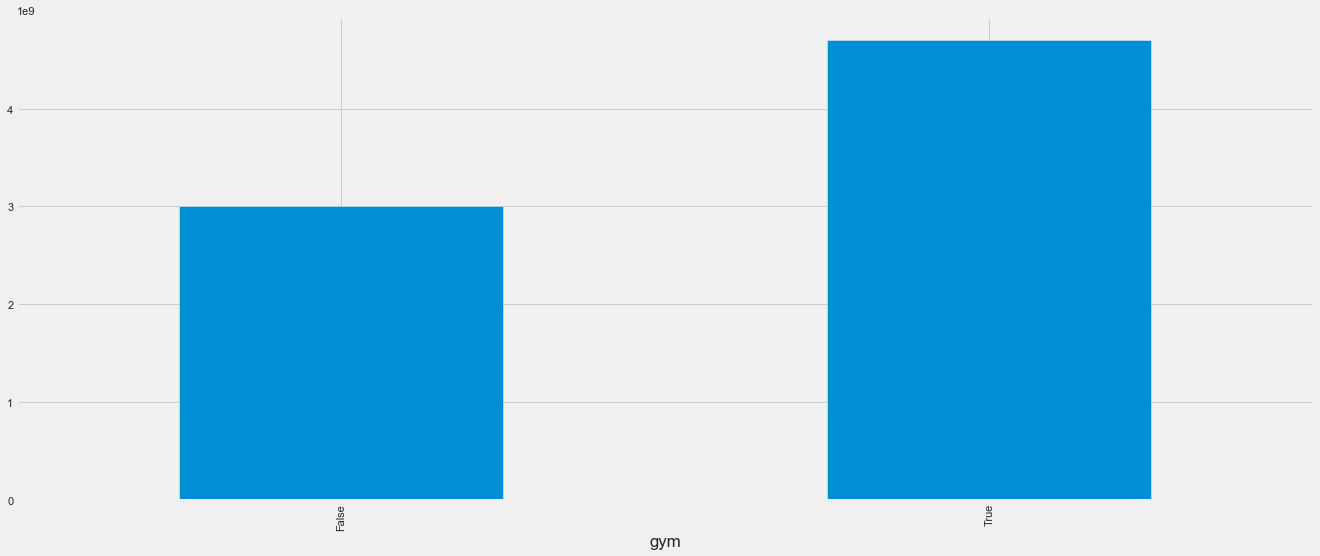

In [24]:
for i in cat:
    print(i)
    df.groupby(i)['harga'].mean().sort_values().plot.bar()
    plt.show()
    df.groupby(i)['harga'].median().sort_values().plot.bar()
    plt.show()

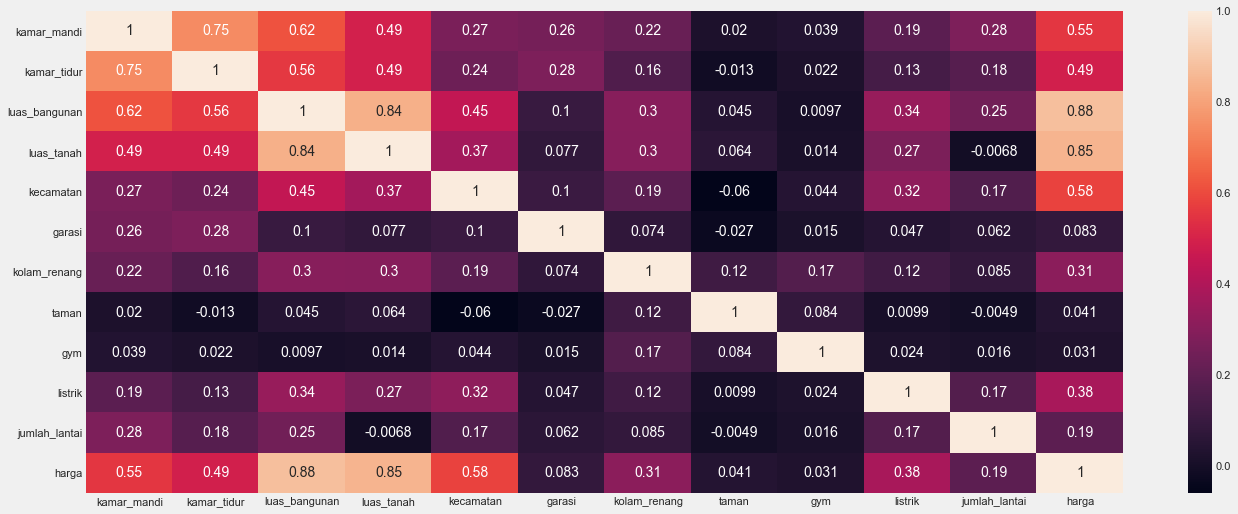

In [25]:
sns.heatmap(initial_data.corr(method = 'spearman'),annot=True)
plt.show()

feature selection

In [26]:
df_selected = df.copy()
df_selected['kamar'] = df_selected['kamar_mandi'] + df_selected['kamar_tidur']
df_selected['km:k'] = df_selected['kamar_mandi'] / df_selected['kamar']
df_selected['lb:lt'] =  df_selected['luas_bangunan'] / df_selected['luas_tanah']
df_selected = df_selected.drop(
    ['kamar_mandi','luas_bangunan','garasi','kamar_tidur','taman','jumlah_lantai','gym'], 
    axis = 1
)

In [27]:
num = [i for i in df_selected.columns if df_selected[i].dtypes in ['int64', 'float']]
cat = [i for i in df_selected.columns if df_selected[i].dtypes in ['O', 'bool']]

In [28]:
from feature_engine.encoding import DecisionTreeEncoder as DTE

In [29]:
encode = DTE(variables = ['kecamatan'])
encode.fit(df_selected,df_selected['harga'])

DecisionTreeEncoder(param_grid={'max_depth': [1, 2, 3, 4]},
                    variables=['kecamatan'])

In [30]:
from feature_engine.encoding import OrdinalEncoder as OE

In [31]:
oe = OE(variables = [i for i in cat if i != 'kecamatan'])
oe.fit(df_selected,df_selected['harga'])

OrdinalEncoder(variables=['kolam_renang'])

In [32]:
x = oe.transform(encode.transform(df_selected))

In [33]:
from sklearn.preprocessing import StandardScaler as ss

In [34]:
x_scale = ss()
x_scale.fit(x.drop('harga',axis = 1))
y_scale = ss()
y_scale.fit(x[['harga']])

StandardScaler()

In [35]:
import statsmodels.api as sm

In [36]:
x = x_scale.transform(x.drop(['harga'],axis = 1))
y = y_scale.transform(df_selected[['harga']])
x = pd.DataFrame(x)
y = pd.DataFrame(y)
x.columns = df_selected.drop('harga', axis = 1).columns
y.columns = ['harga']
initial_data = pd.concat([x,y],axis = 1)
x = sm.add_constant(x)

In [37]:
model = sm.OLS(y, x).fit()

In [38]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  harga   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     2947.
Date:                Tue, 06 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:49:59   Log-Likelihood:                -11353.
No. Observations:               12266   AIC:                         2.272e+04
Df Residuals:                   12258   BIC:                         2.278e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.469e-17      0.006   6.29e-15      1.000      -0.011       0.011
luas_tanah       0.4808      0.007     70.009      0.000       0.467       0.494
kecamatan        0.4455      0.006     75.142      0.000       0.434       0.457
kolam_renang     0.0419      0.006      7.158      0.000       0.030       0.053
listrik          0.0573      0.006     10.124      0.000       0.046       0.068
kamar            0.0351      0.006      5.658      0.000       0.023       0.047
km:k             0.0204      0.006      3.571      0.000       0.009       0.032
lb:lt            0.0649      0.006     10.745      0.000       0.053       0.077
==============================================================================
Omnibus:                    15653.809   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18943818.173
Skew:                           6.298   Prob(JB):                         0.00
Kurtosis:                     195.113   Cond. No.                         2.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
pd.DataFrame(model.params).reset_index().sort_values(by = 0, ascending = False)

,index,0
1,luas_tanah,4.807906e-01
2,kecamatan,4.455011e-01
7,lb:lt,6.485140e-02
4,listrik,5.733830e-02
3,kolam_renang,4.192572e-02
5,kamar,3.512201e-02
6,km:k,2.036067e-02
0,const,3.469447e-17


In [40]:
y_pred = model.predict(x)
sqrt(mse(y_pred, y))

0.6105451218077979

EDA selected feature

luas_tanah


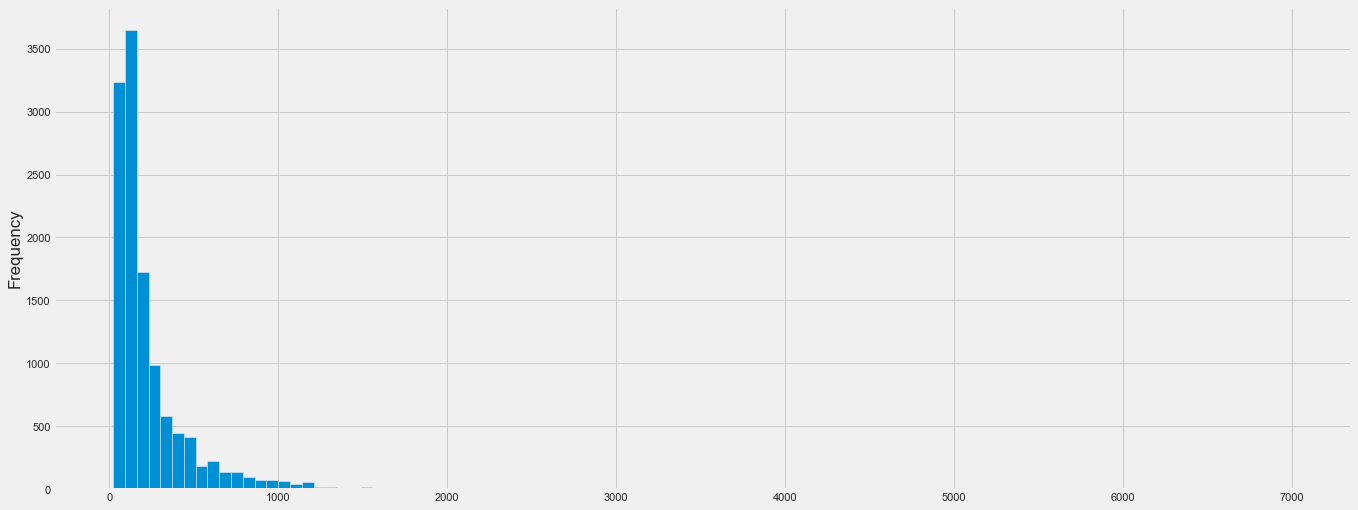

harga


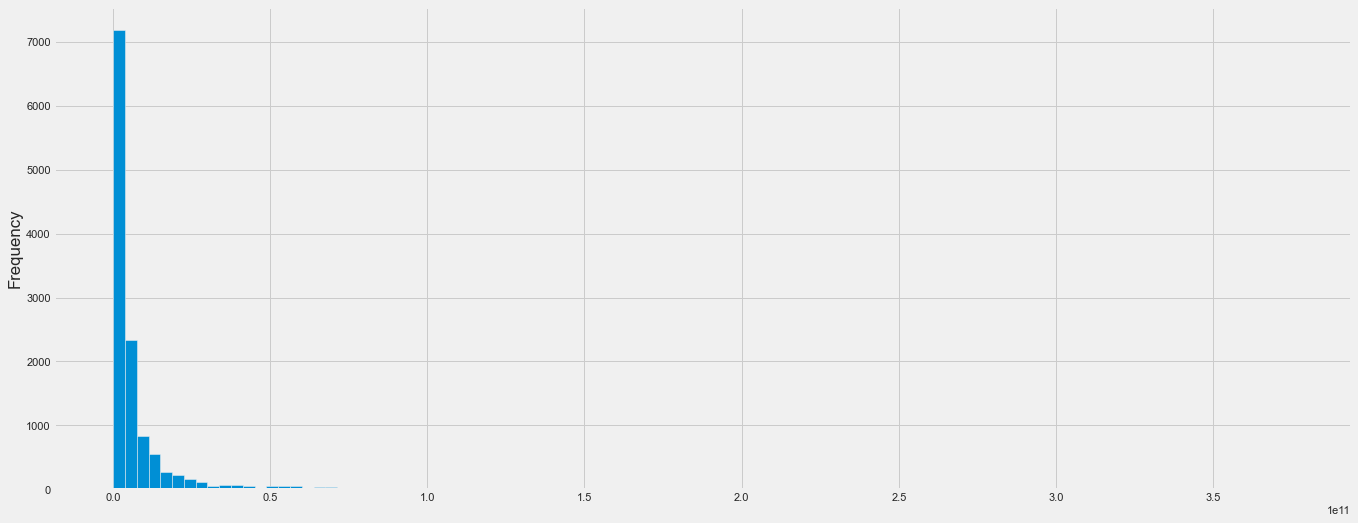

listrik


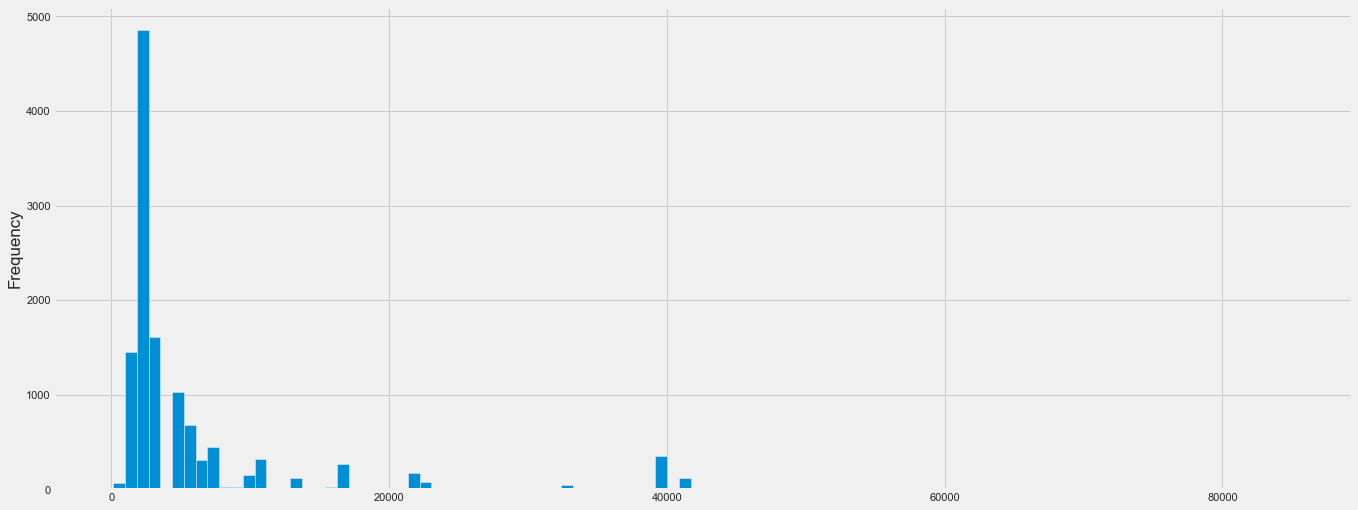

kamar


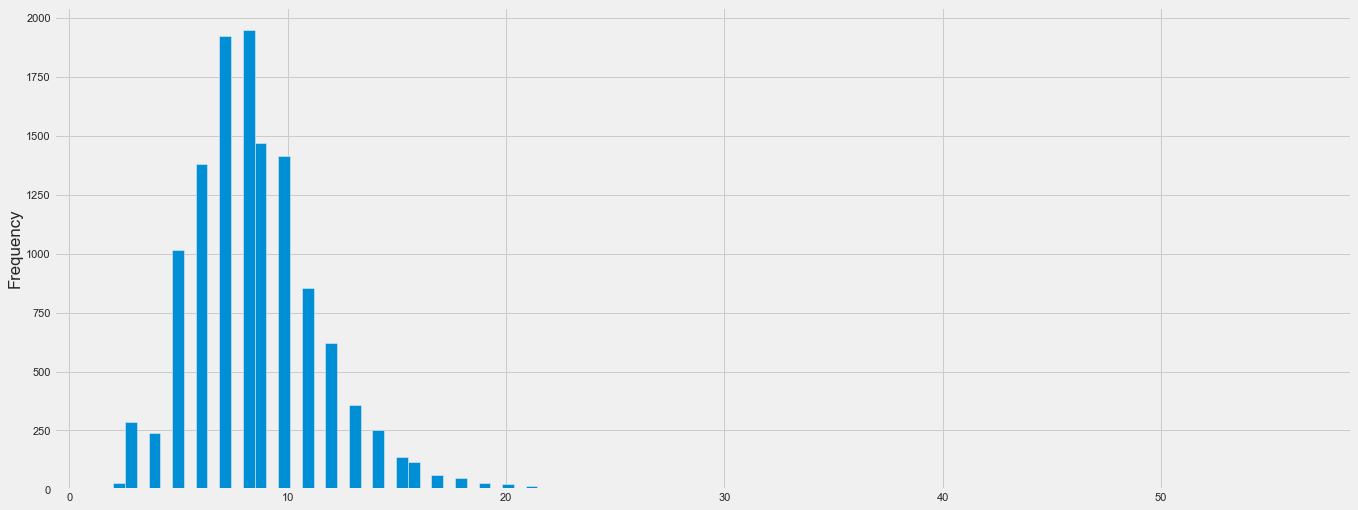

km:k


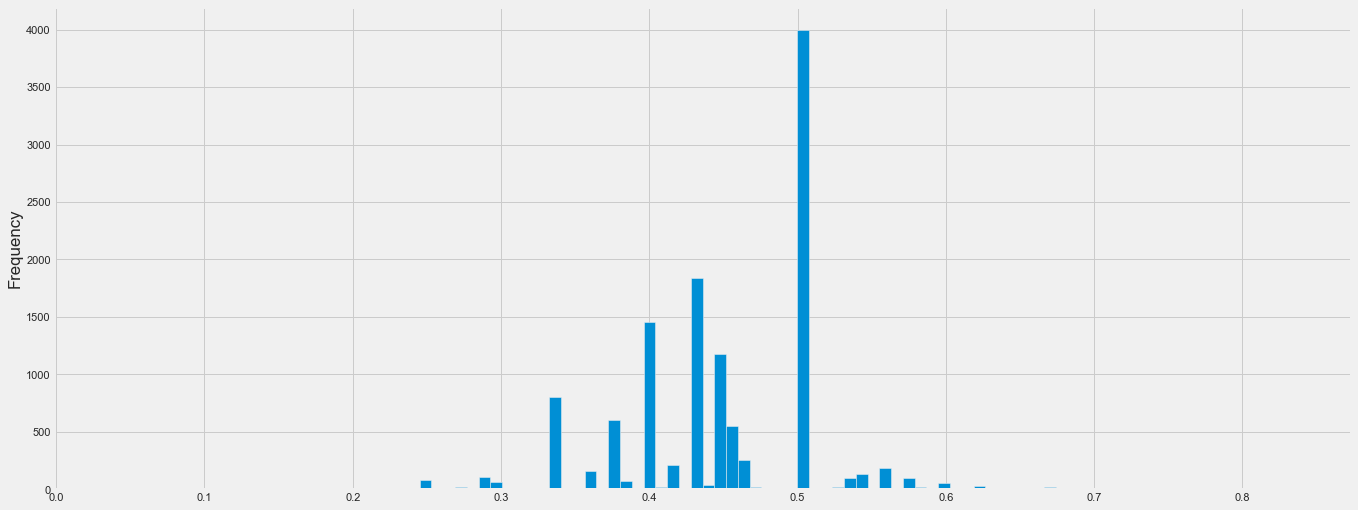

lb:lt


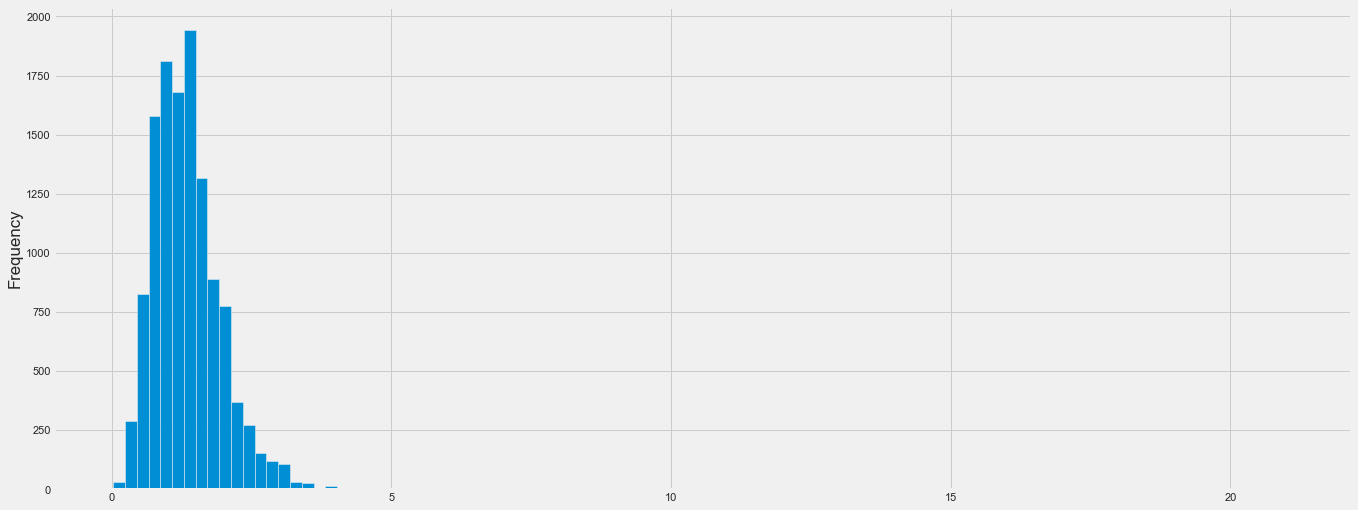

In [41]:
for i in num:
    print(i)
    df_selected[i].plot.hist(bins = 100)
    plt.show()

luas_tanah


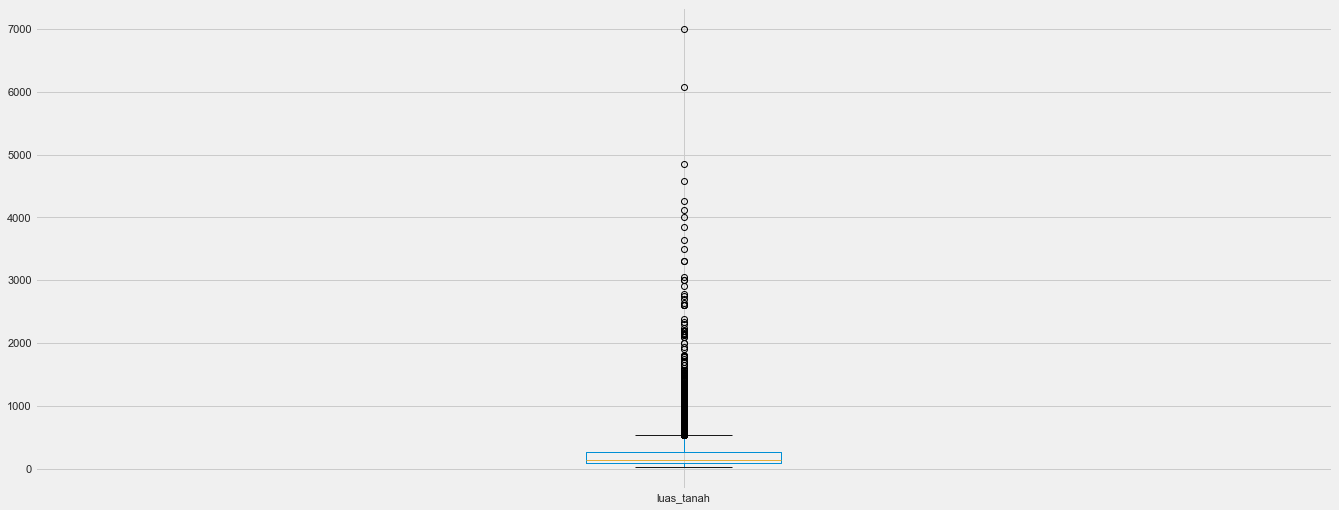

harga


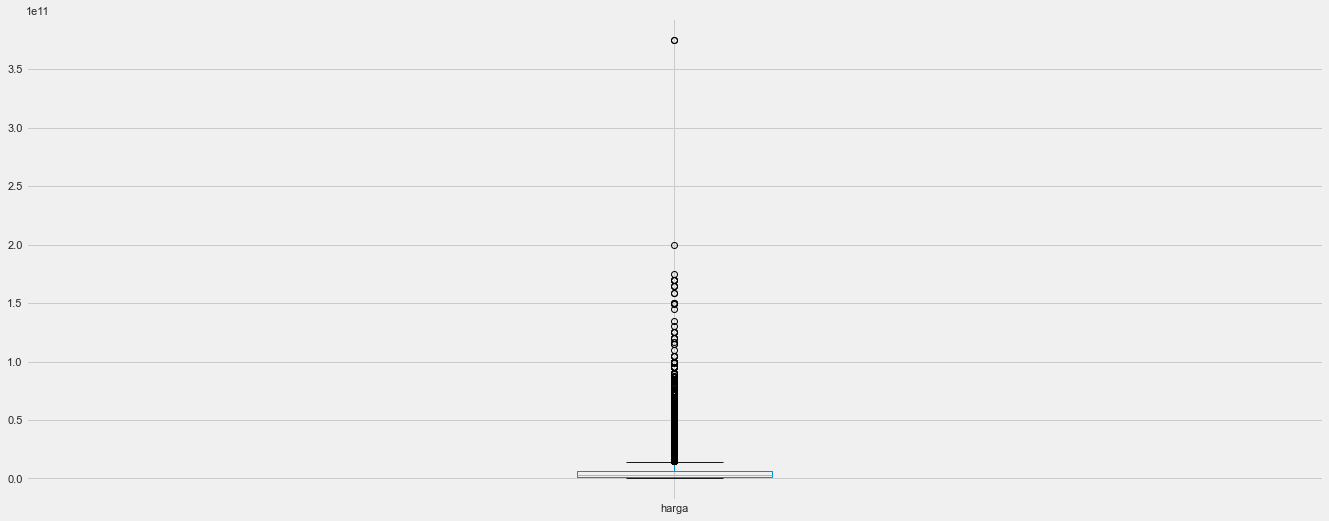

listrik


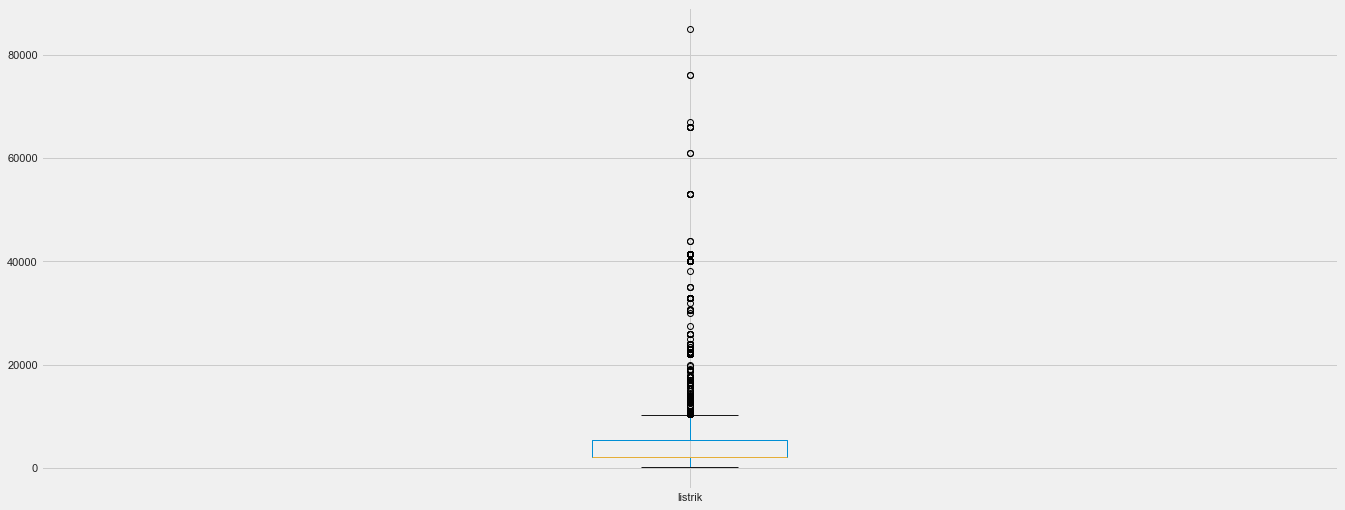

kamar


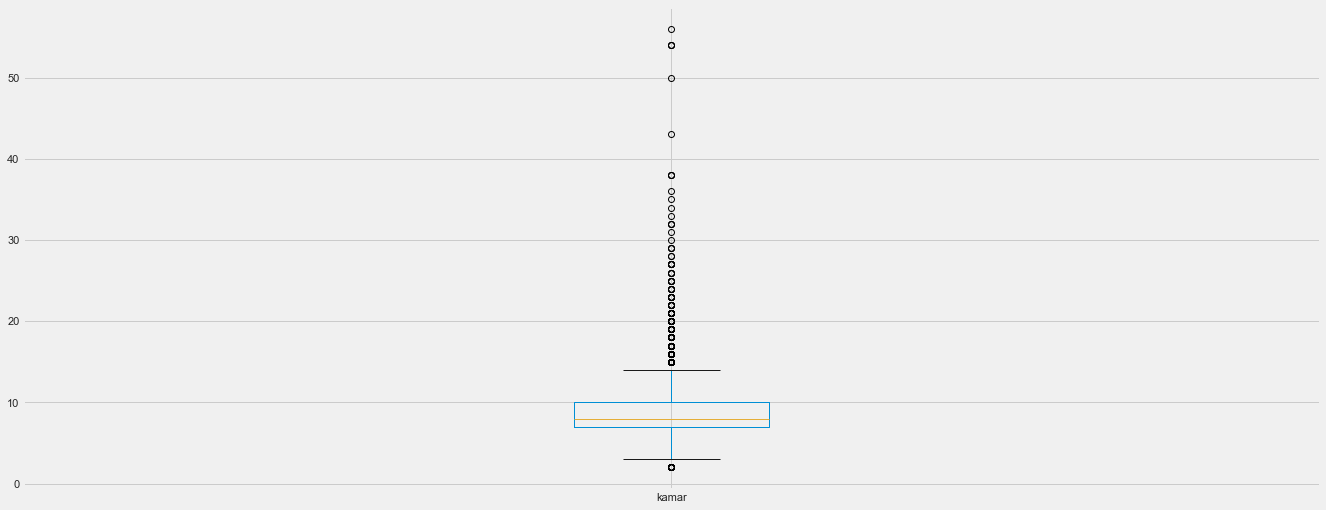

km:k


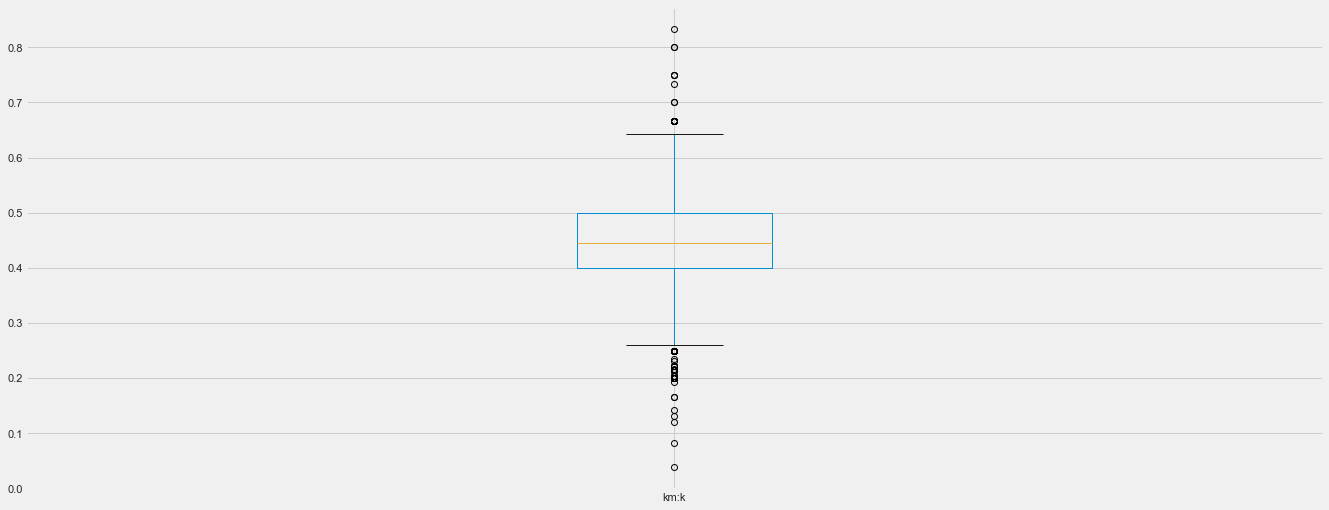

lb:lt


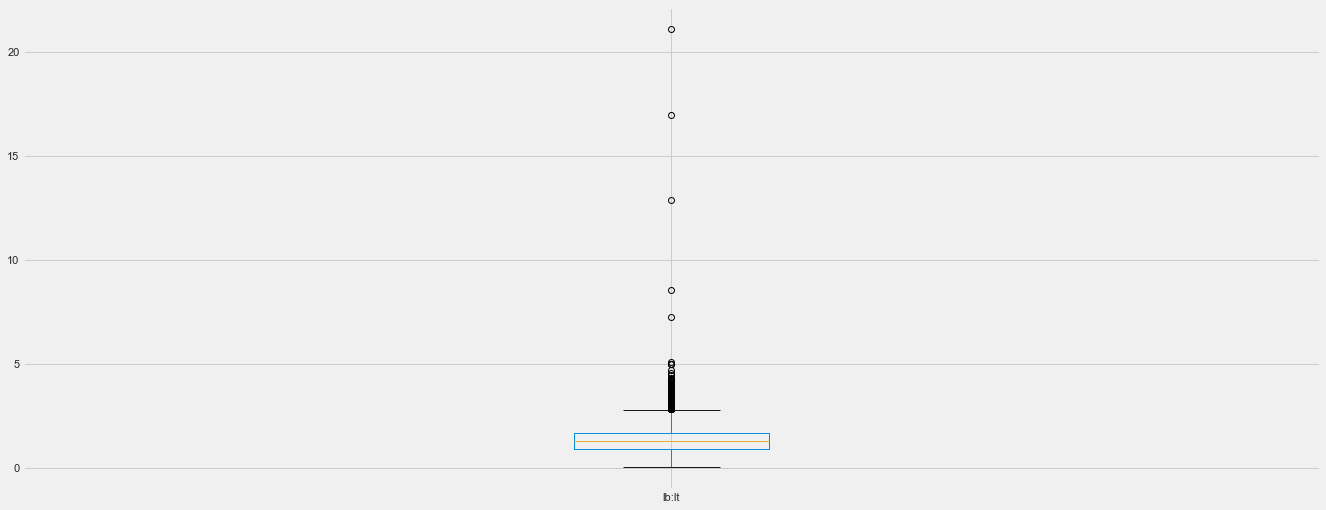

In [42]:
for i in num:
    print(i)
    df_selected[i].plot.box()
    plt.show()

kecamatan


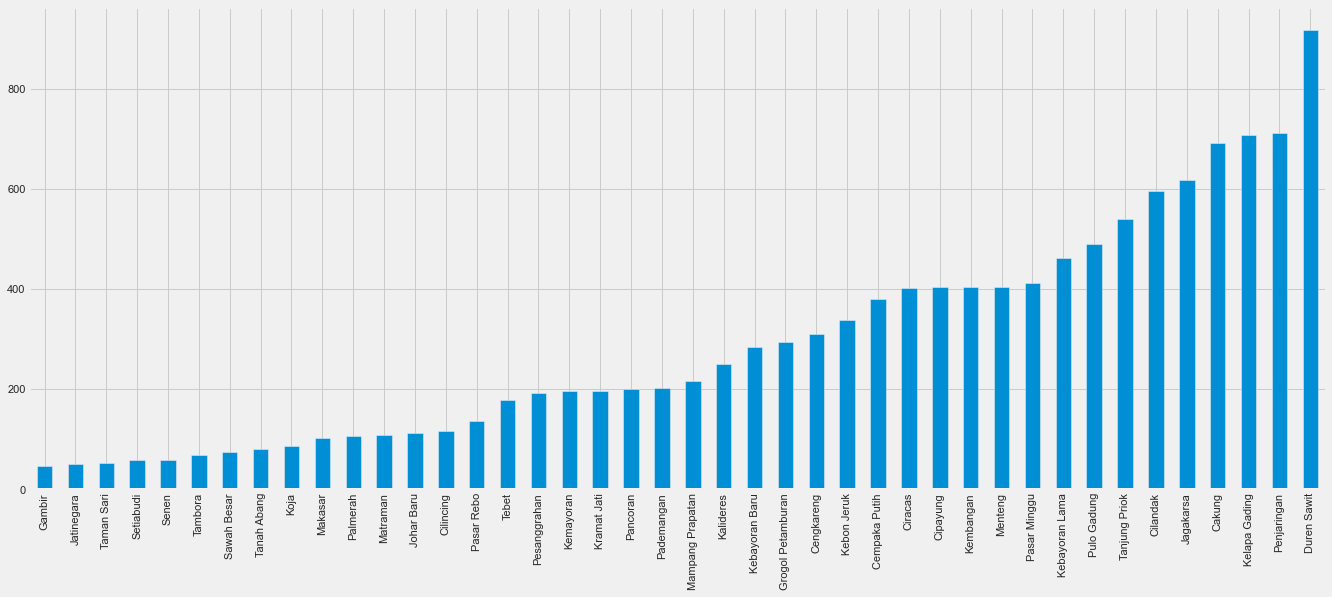

kolam_renang


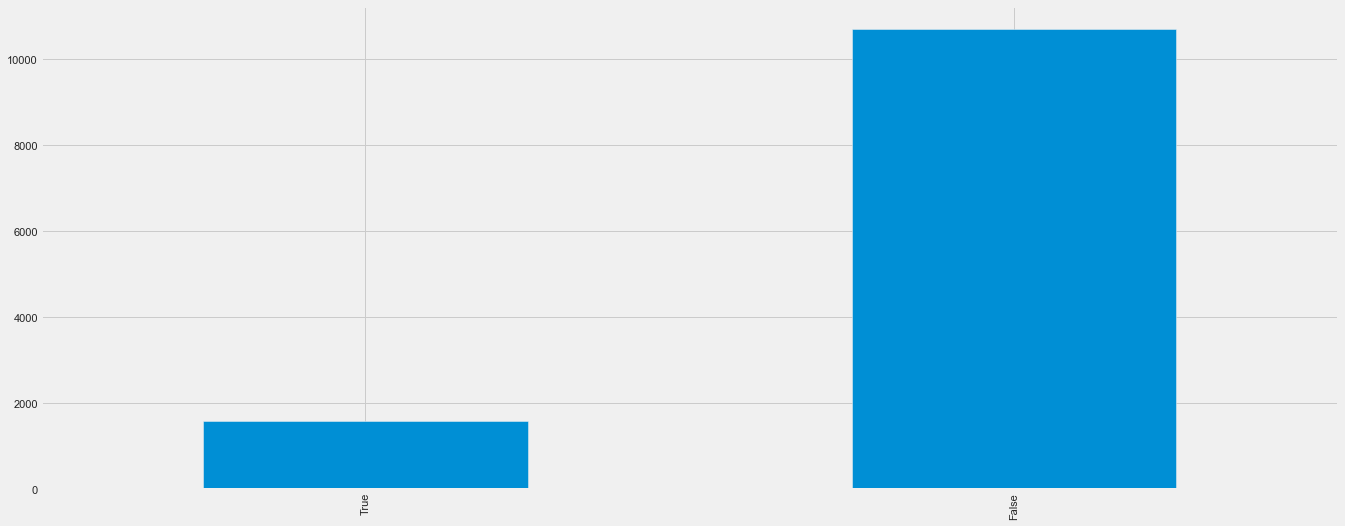

In [43]:
for i in cat:
    print(i)
    df_selected[i].value_counts().sort_values().plot.bar()
    plt.show()

luas_tanah


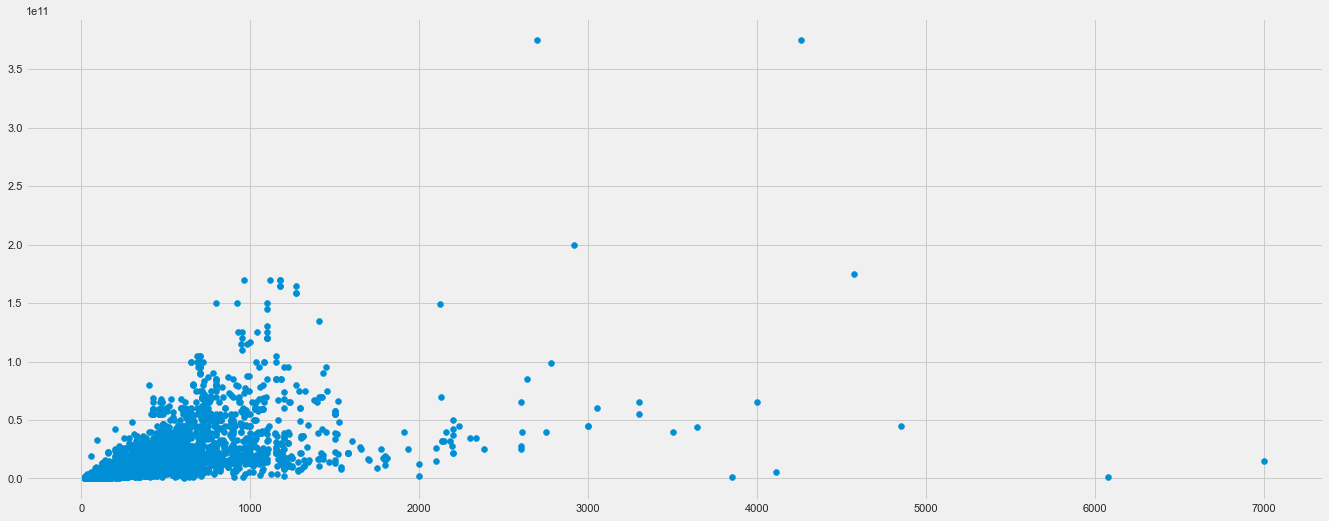

listrik


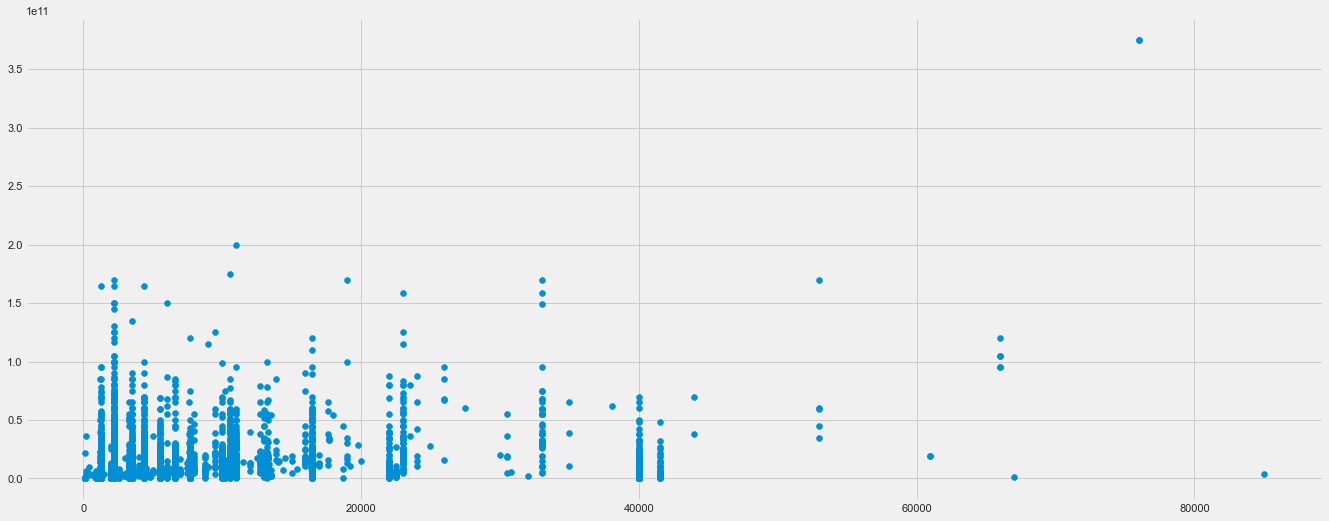

kamar


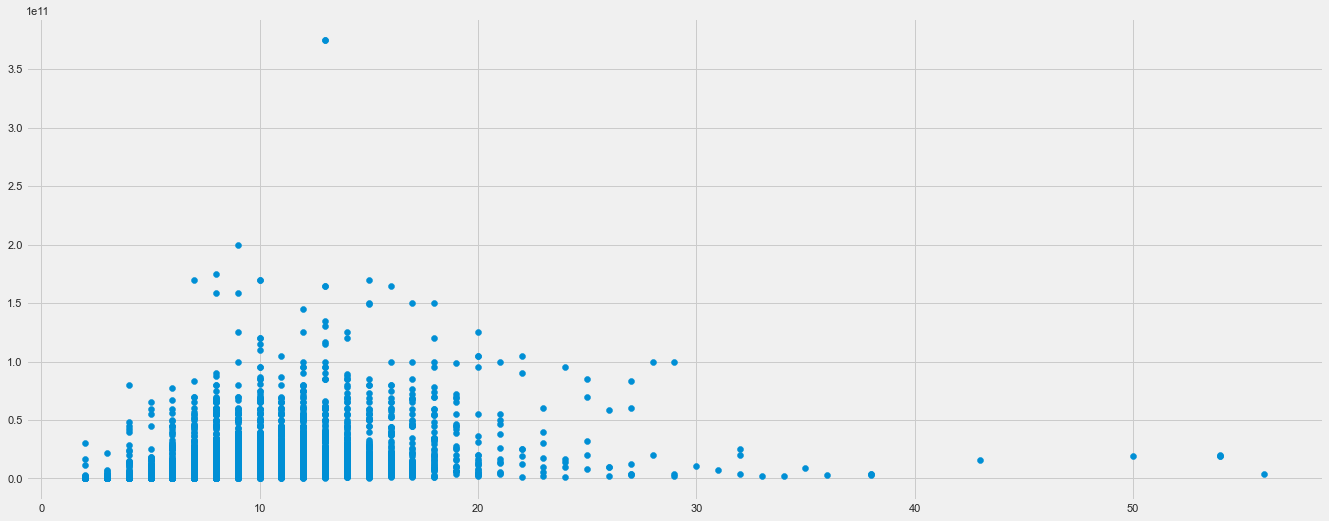

km:k


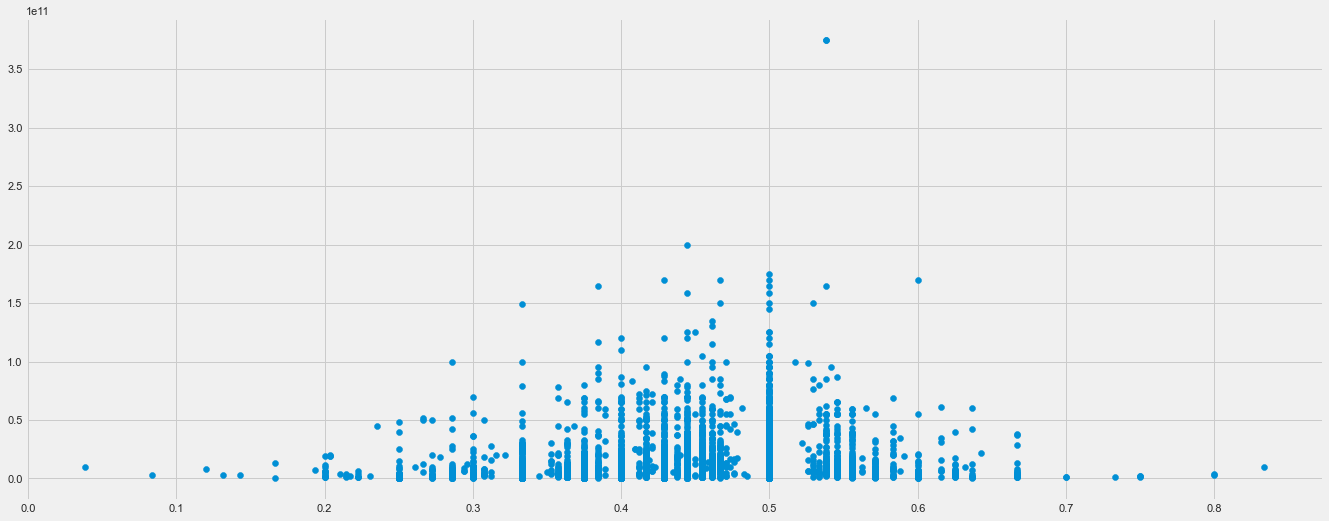

lb:lt


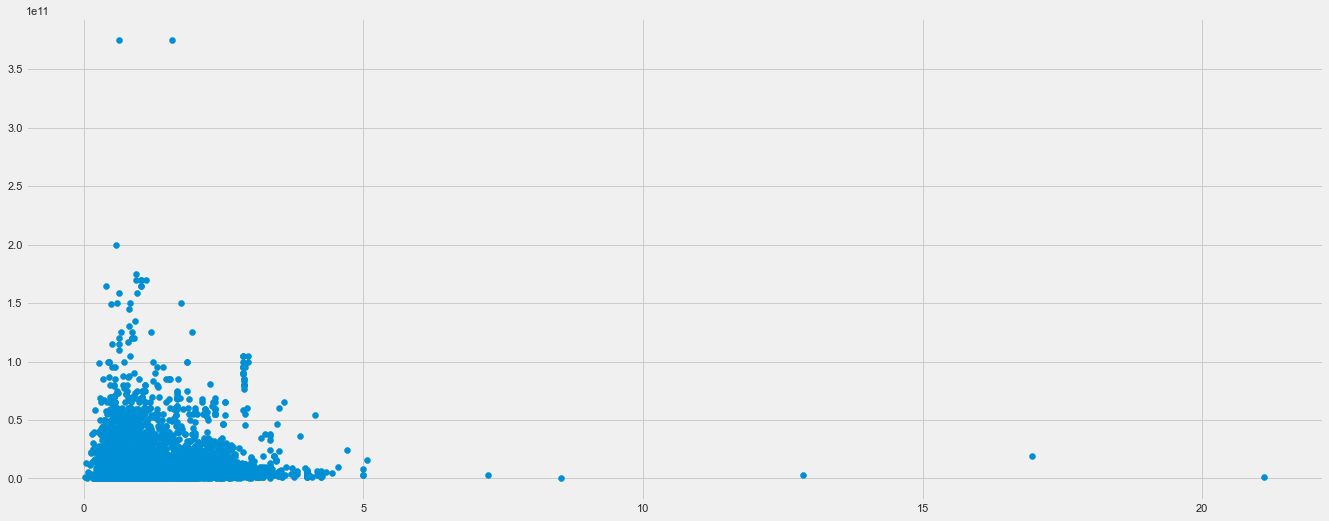

kecamatan


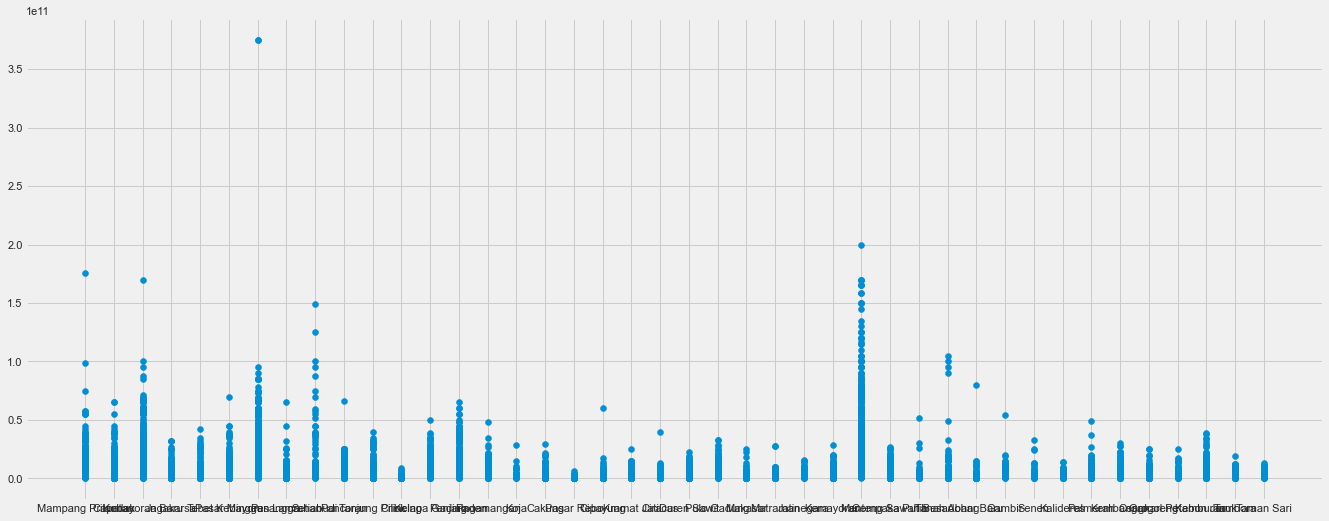

kolam_renang


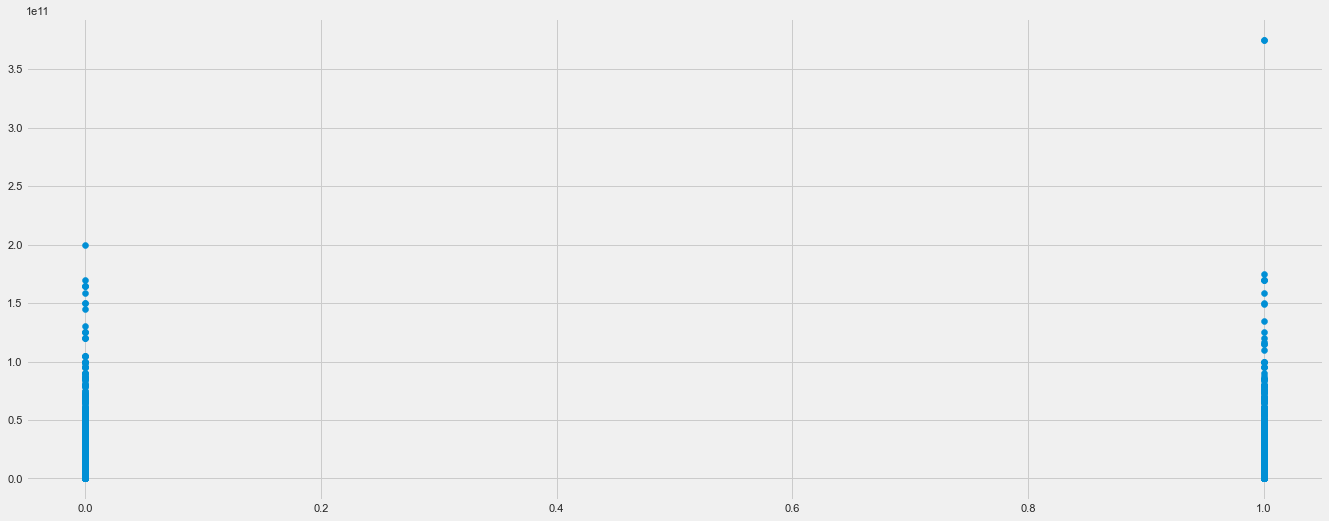

In [44]:
for i in num+cat:
    if i != 'harga':
        print(i)
        plt.scatter(df_selected[i],df_selected['harga'])
        plt.show()

kecamatan


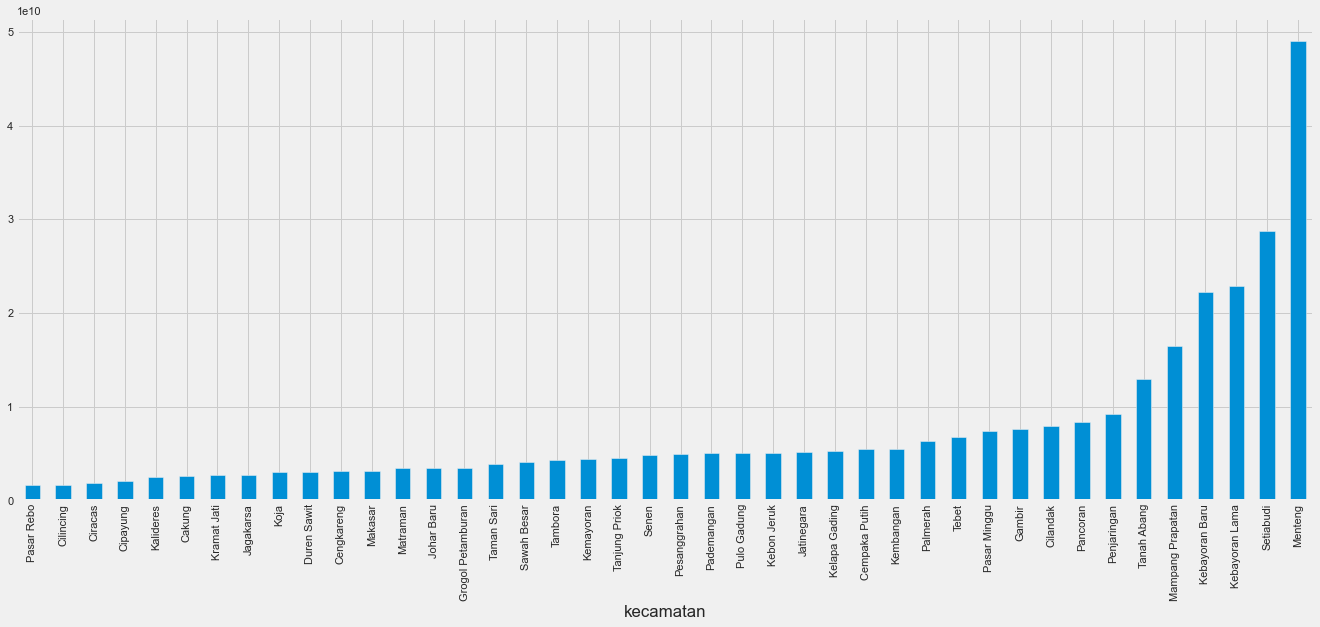

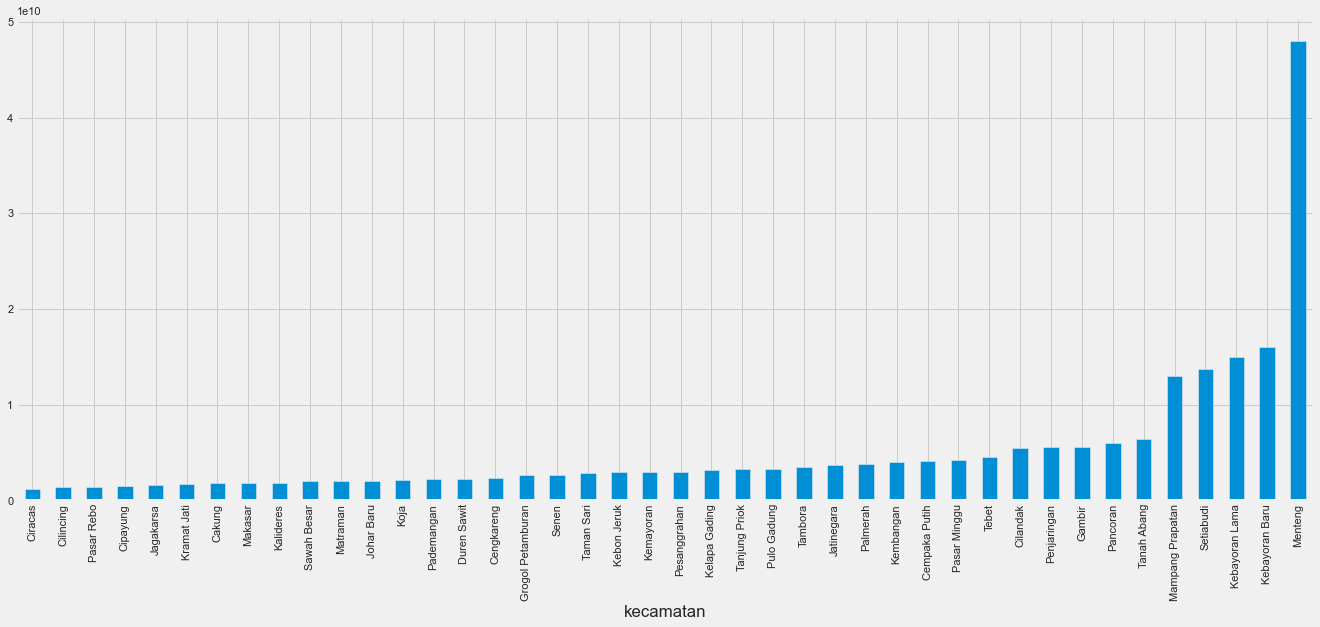

kolam_renang


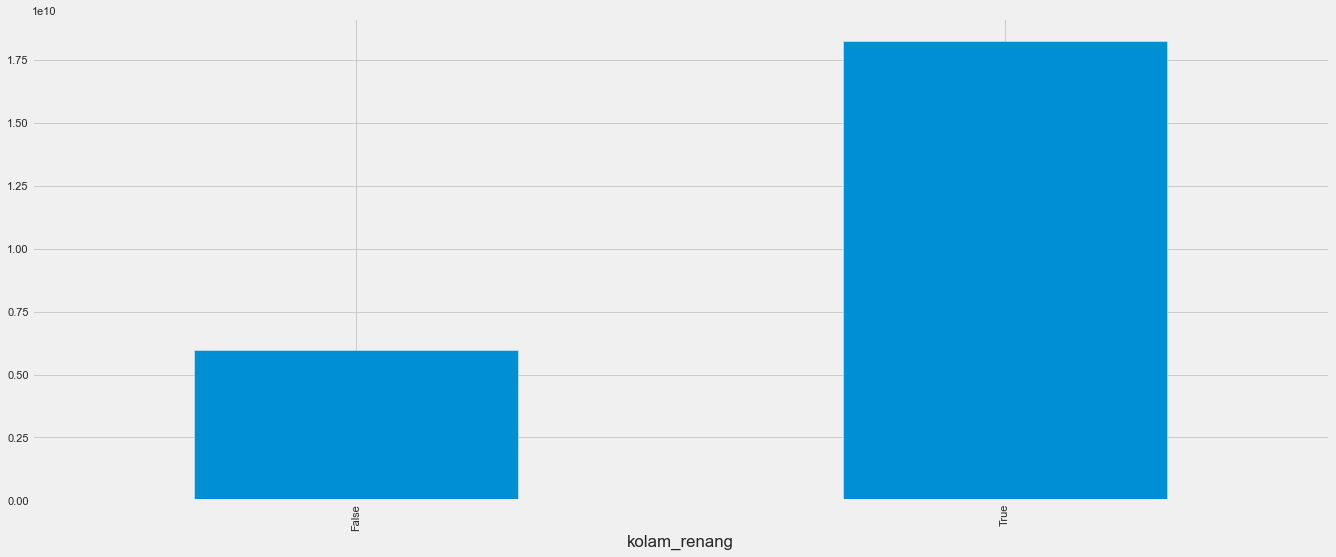

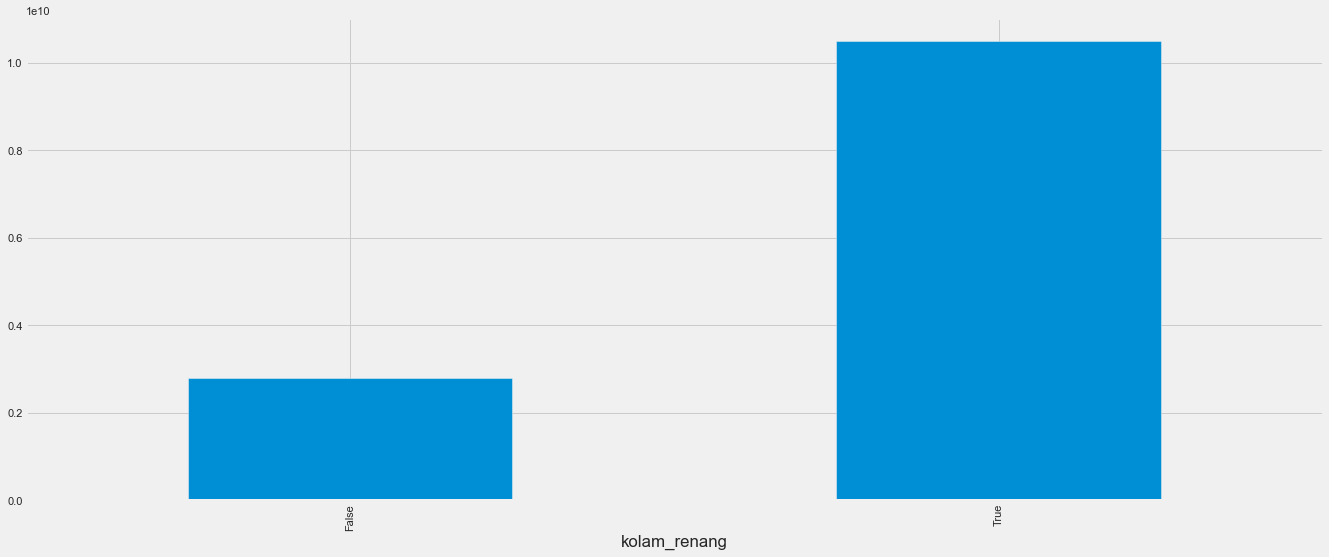

In [45]:
for i in cat:
    print(i)
    df_selected.groupby(i)['harga'].mean().sort_values().plot.bar()
    plt.show()
    df_selected.groupby(i)['harga'].median().sort_values().plot.bar()
    plt.show()

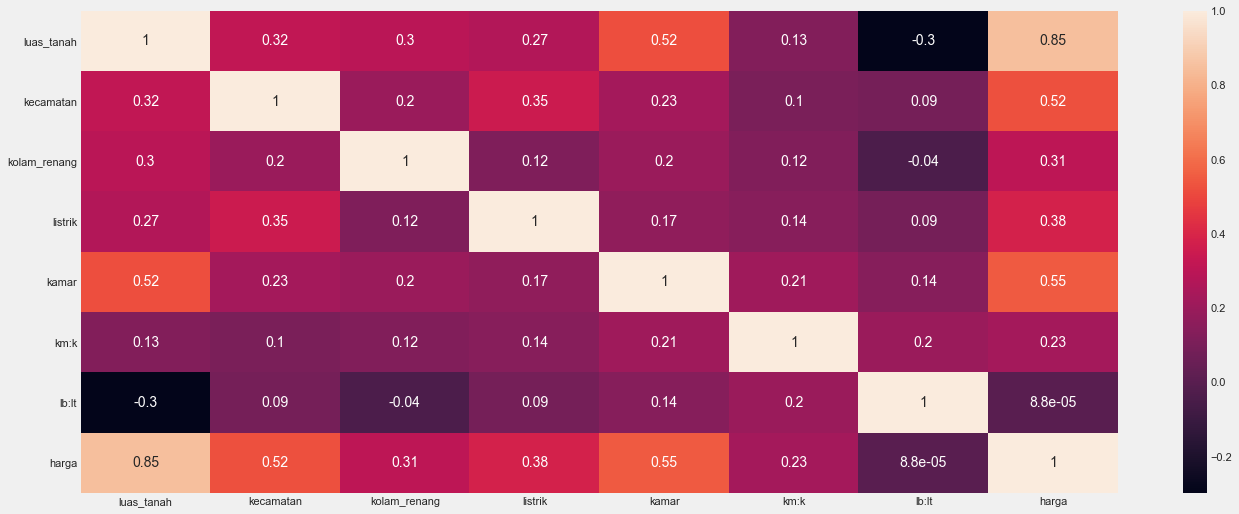

In [46]:
sns.heatmap(initial_data.corr(method = 'spearman'),annot=True)
plt.show()

Regression

In [47]:
from sklearn.model_selection import train_test_split as TTS

In [48]:
x_train, x_test, y_train, y_test = TTS(
    df_selected.drop('harga', axis = 1),
    df_selected['harga'],
    test_size = 0.3,
    random_state = 0
)

In [49]:
encode = DTE(variables = ['kecamatan'])
x_train = encode.fit_transform(x_train, y_train)
x_test = encode.transform(x_test)

In [50]:
oe = OE(variables = [i for i in cat if i != 'kecamatan'])
x_train = oe.fit_transform(x_train, y_train)
x_test = oe.transform(x_test)

In [51]:
scale = ss()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [52]:
from feature_engine.transformation import LogTransformer as LT
transformer = LT()
y_train = transformer.fit_transform(pd.DataFrame(y_train))
y_test = transformer.transform(pd.DataFrame(y_test))

In [53]:
from sklearn.linear_model import LinearRegression as LR

In [54]:
reg = LR().fit(x_train,y_train)

In [55]:
reg.coef_

array([[0.5288325 , 0.32400589, 0.09544048, 0.04595488, 0.25284355,
        0.10999461, 0.09605114]])

In [56]:
train_predict = reg.predict(x_train)
test_predict = reg.predict(x_test)

In [65]:
under_zero = 0 
for i in train_predict:
    if i < 0 :
        under_zero += 1
for i in test_predict:
    if i < 0 :
        under_zero += 1
under_zero

0

In [57]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

In [58]:
print('train mse: {}'.format(mean_squared_error(y_train, train_predict)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, train_predict))))
print('train r2: {}'.format(r2_score(y_train, train_predict)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, test_predict)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, test_predict))))
print('test r2: {}'.format(r2_score(y_test, test_predict)))

train mse: 0.43737500798001777
train rmse: 0.6613433359307537
train r2: 0.6414903952569871

test mse: 0.4617688039666557
test rmse: 0.6795357267772282
test r2: 0.6371580858933302


In [59]:
x = np.concatenate((x_train,x_test))
y = np.concatenate((y_train,y_test))

In [60]:
from sklearn.model_selection import cross_val_score

In [61]:
scores = cross_val_score(reg, x, y, cv=5, scoring = 'r2')
print(scores)
print(scores.mean())

[0.64278312 0.60387023 0.65549563 0.65959833 0.62283212]
0.636915883463699


In [62]:
from yellowbrick.regressor import ResidualsPlot

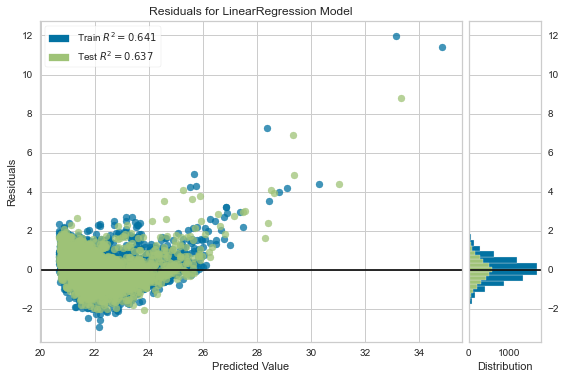

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [63]:
model = reg
visualizer = ResidualsPlot(model)
visualizer.fit(x_train, y_train) 
visualizer.score(x_test, y_test) 
visualizer.show()                 

### Simpulan
- Data yang di peroleh tidak cukup bagus. hal tersebut dibuktikan dari nilai R2 dari regresi lienar menggunakan base model sebesar 0.565, yang artinya model tersebut tidak terlalu kuat(moderate:0.5-0.7) tetapi model tersebut masih dapat diterima (Falk and Miller (1992)). Terdapat kenaikan nilai r2 sebesar 0.1 jika pada dataset tersebut di lakukan feature engineering dan feature selection. Pemilihan feature tersebut berdasarkan hasil dari summary statsmodels, yang mana feature yang dipilih adalah feature yang memiliki p-val < 0.05. 


- Salah satu asumsi dari linear regression adalah no multicolinearity. Pada dataset ini, beberapa feature memiliki korelasi yang tinggi. Oleh karena itu dilakukan feature engineering berdasarkan korelasi antar fitur dan tetap mempertahankan informasi yang ada.


- Semua feature yang digunakan dalam dataset ini memiliki korelasi positif terhadap harga. tetapi, dalam regresi linier menggunakan OLS terdapat koefisien negatif. hal tersebut terjadi karena pengaruh feature tersebut terhadap harga lebih kecil dibanding feature lain. Selain itu p-value dari feature tersebut lebih besar dari 0.05, yang artinya feature tersebut dianggap tidak terlalu penting dalam regresi. Setelah dilakukan feature engineering dan feature selection, semua feature memiliki koefisien yang positif.


- Untuk feature harga, dilakukan transformasi logaritmik karena distribusinya right skew. Hal tersebut dilakukan mengingat salah satu asumsi dari linear regression adalah normal distribution.


- Dengan menggunakan model regresi linear, diperoleh r2 score sebesar 0.64 pada train set dan 0.63 pada test set. Pada cross validation, diperoleh rata-rata r2 score sebesar 0.63. dengan demikian dapat dikatakan bahwa model tersebut tidak overfitting. 


- Pada Grafik residual plot, diperoleh distribusinya heteroscedascity. Penyebab terjadinya distribusi tersebut karena beberapa feature memiliki distribusi skew. Selain itu penyebab heteroscedascity yang lain adalah hilangnya feature yang penting pada dataset tersebut.


- Dengan menggunakan slovin's formula, sample size = len df dan population size didapat dari situs bps, diperoleh margin of error sebesar +-0.9%


- Median dan mean harga rumah tertinggi berdasarkan kecamatan adalah daerah Menteng. Harga rumah di daerah menteng memiliki harga rumah yang cukup signifikan dibandingkan dengan daerah lain. Hal tersebut dibuktikan dari A/B test.